# Stroke Prediction Dataset

**11 clinical features for predicting stroke events**

*В данном исследовании попробуем предсказать инсульт у пациента, опираясь на различные характеристики. Датасет взят с [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)*

## 1. Импорты библиотек

In [41]:
import warnings
warnings.filterwarnings('ignore')

from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier, 
    StackingClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score, 
    recall_score, 
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    cross_val_predict, 
    StratifiedKFold,
    train_test_split    
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier
from hyperopt import hp, fmin, STATUS_OK, tpe, Trials
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## 2. Загрузка датасета

Импортируем необходимые модули для работы с файлами и API Kaggle

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
from zipfile import ZipFile

Определим две константы. **DATASET_NAME** берём из Kaggle API команды, а в **PATH** запишем каталог, в который сохраним csv-файл с датасетом

In [3]:
DATASET_NAME = 'fedesoriano/stroke-prediction-dataset'
PATH = 'data'

In [4]:
def load_dataset():
    if not Path(PATH).is_dir():
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(DATASET_NAME, path=PATH)
        zip_path = PATH + '/' + DATASET_NAME.split('/')[1] + '.zip'
        with ZipFile(zip_path, 'r') as zip:
            zip.extractall(PATH)
        Path(zip_path).unlink(missing_ok=True)
    return pd.read_csv(Path(PATH).iterdir().__next__(), sep=',')

In [5]:
stroke = load_dataset()

## 3. Исследуем датасет

In [6]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Оценим размер датасета

In [7]:
stroke.shape

(5110, 12)

In [8]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Как видно, пропуски только в **bmi**. По остальным признакам пропуски отсутствуют

In [9]:
stroke.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


О нет! В **gender** мы видим 3 пола! Рассмотрим данный признак подробнее

In [10]:
stroke.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

У одного из пациентов (к счастью всего у одного) возникли проблемы с определением пола. Заменим Other на Female

In [11]:
stroke.replace('Other', 'Female', inplace=True)

In [12]:
stroke.gender.value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

In [13]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Можно увидеть, что инсульт был примерно у 5% испытуемых. Примерно столько же человек страдает от сердечных заболеваний. Повышенное давление наблюдается примерно у 10% пациентов. Средний возраст составляет примерно 43 года.

Проверим датасет на дубликаты

In [14]:
stroke.duplicated().sum()

0

Отлично, дубликатов нет!

Удалим сразу столбец **id**, так как он не представляет никакого интереса

In [15]:
stroke.drop('id', axis=1, inplace=True)

Далее рассмотрим, как распределены инсульты по разным группам пациентов

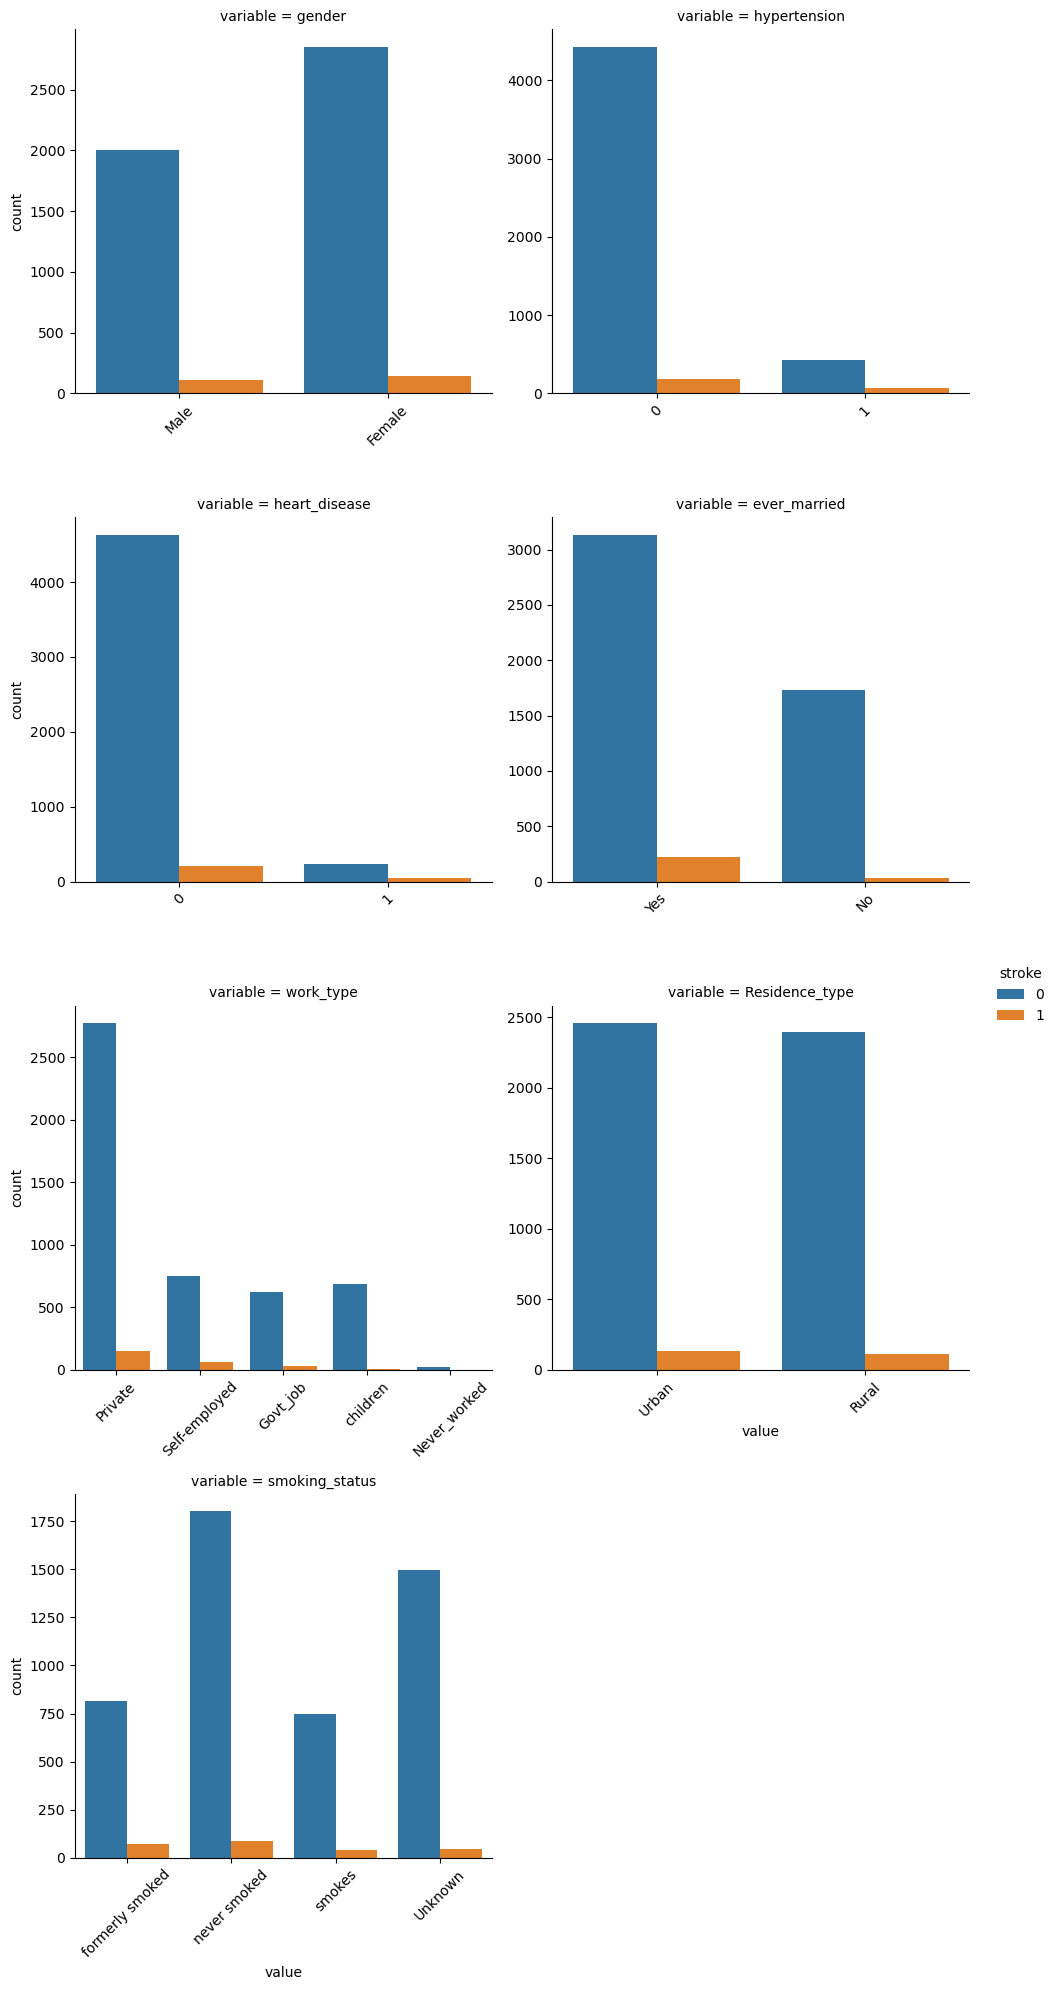

In [16]:
g=sns.catplot(
    x='value',
    hue='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    kind='count',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

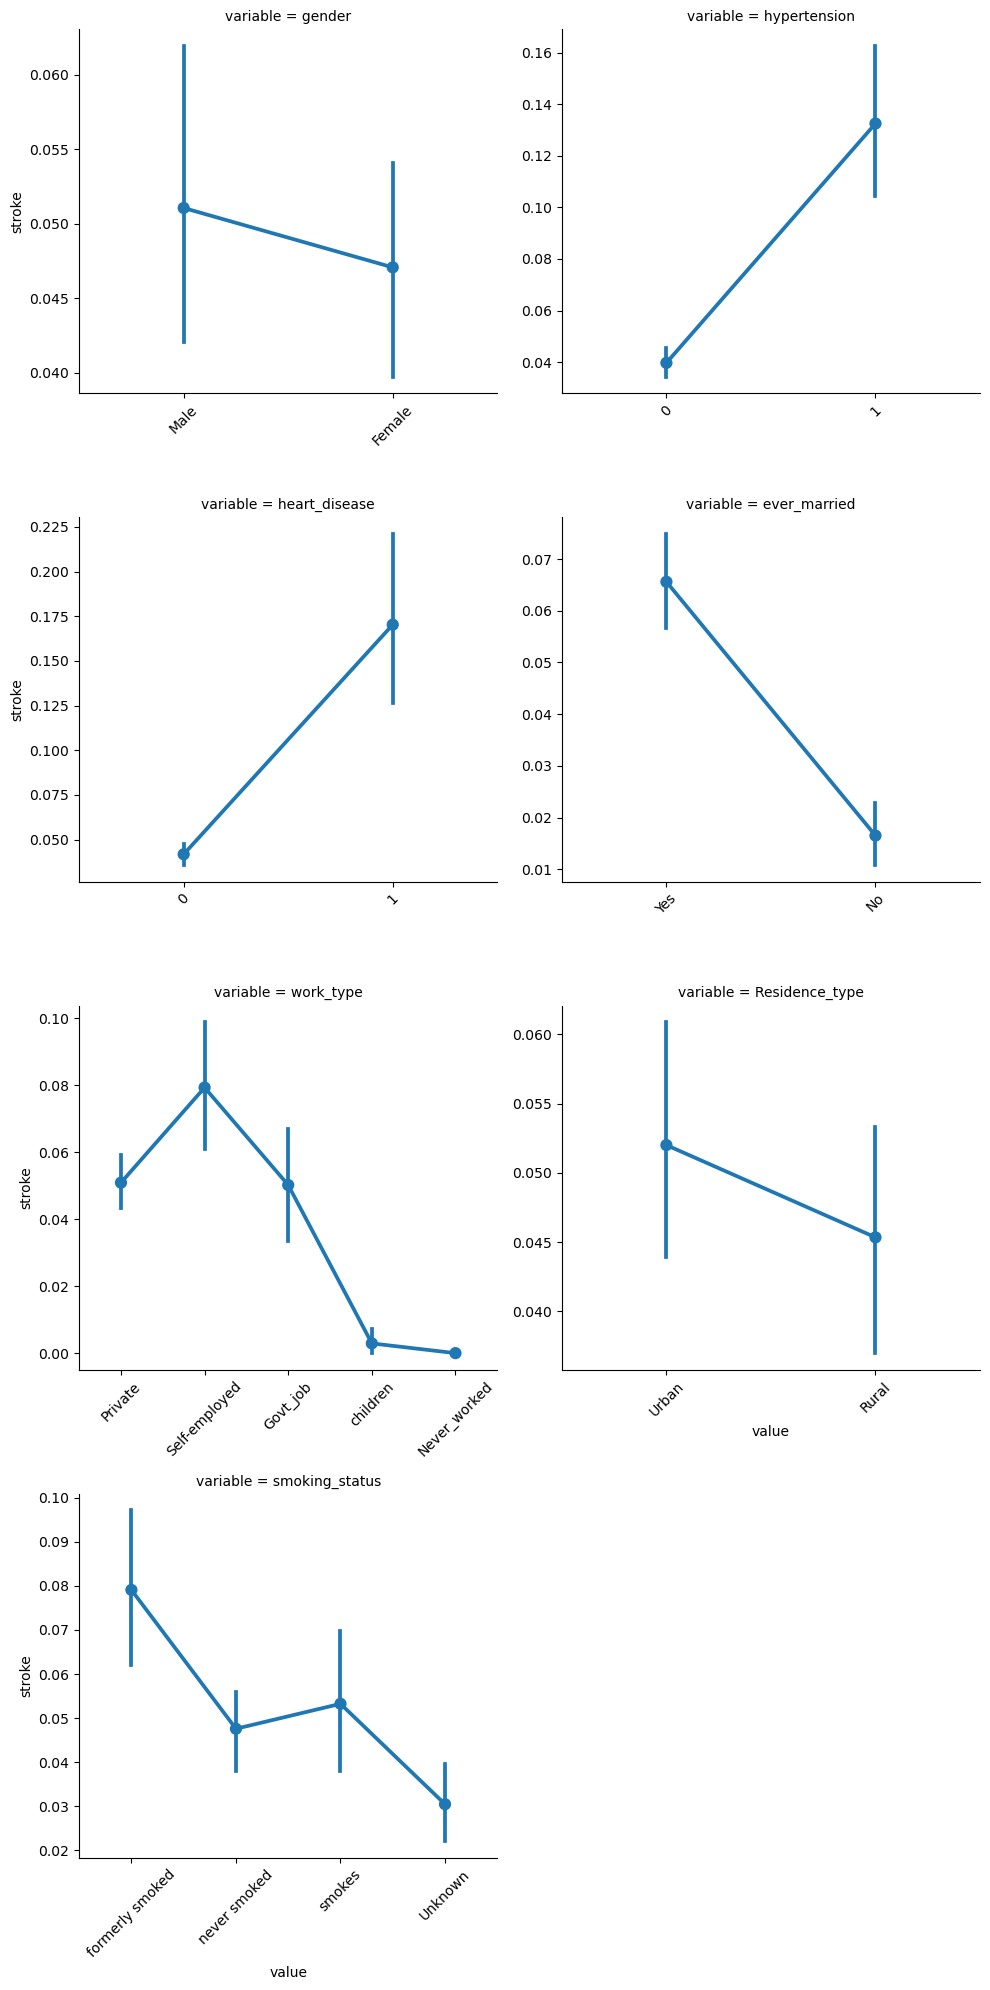

In [17]:
g=sns.catplot(
    x='value',
    y='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Что интересного можно увидеть из этих графиков:
- вероятность инсульта у мужчин немного выше, чем у женщин
- у пациентов с гипертонией вероятность инсульта примерно в 3 раза выше
- у пациентов с сердечными заболеваниями вероятность инсульта тоже примерно в 3 раза выше
- те, кто никогда не состоял в браке, заболевают инсультом более чем в 3 раза реже
- наиболее часто инсульт встречается у самозанятых и почти не встречается у тех, кто не работает (интересно получается!)
- бывшие курильщики больше других подвержены инсультам (даже больше чем курящие)
- живущие в городе чуть чаще подвержены инсультам

Рассмотрим, как выглядят признаки по половому различию

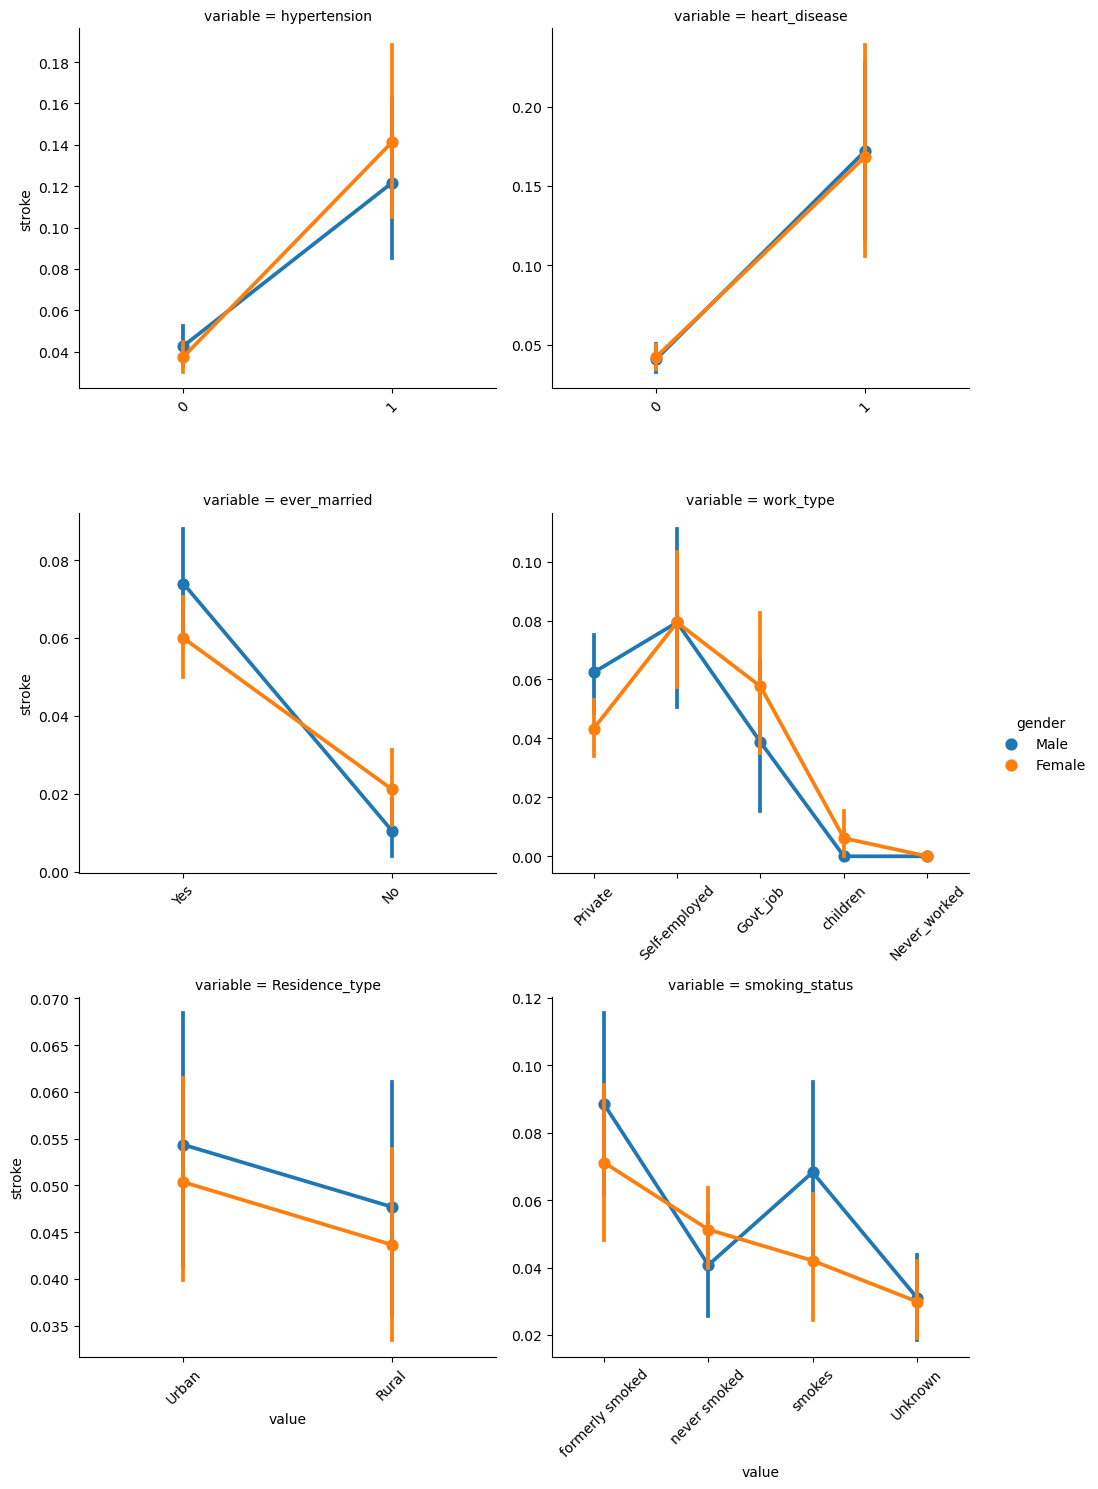

In [18]:
g=sns.catplot(
    x='value',
    y='stroke',
    data=stroke.melt(
        id_vars=['stroke', 'gender'],
        value_vars=stroke.select_dtypes([object, int])
    ),
    col='variable',
    hue='gender',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Ничего существенного!

Теперь рассмотрим как распределены количественные признаки

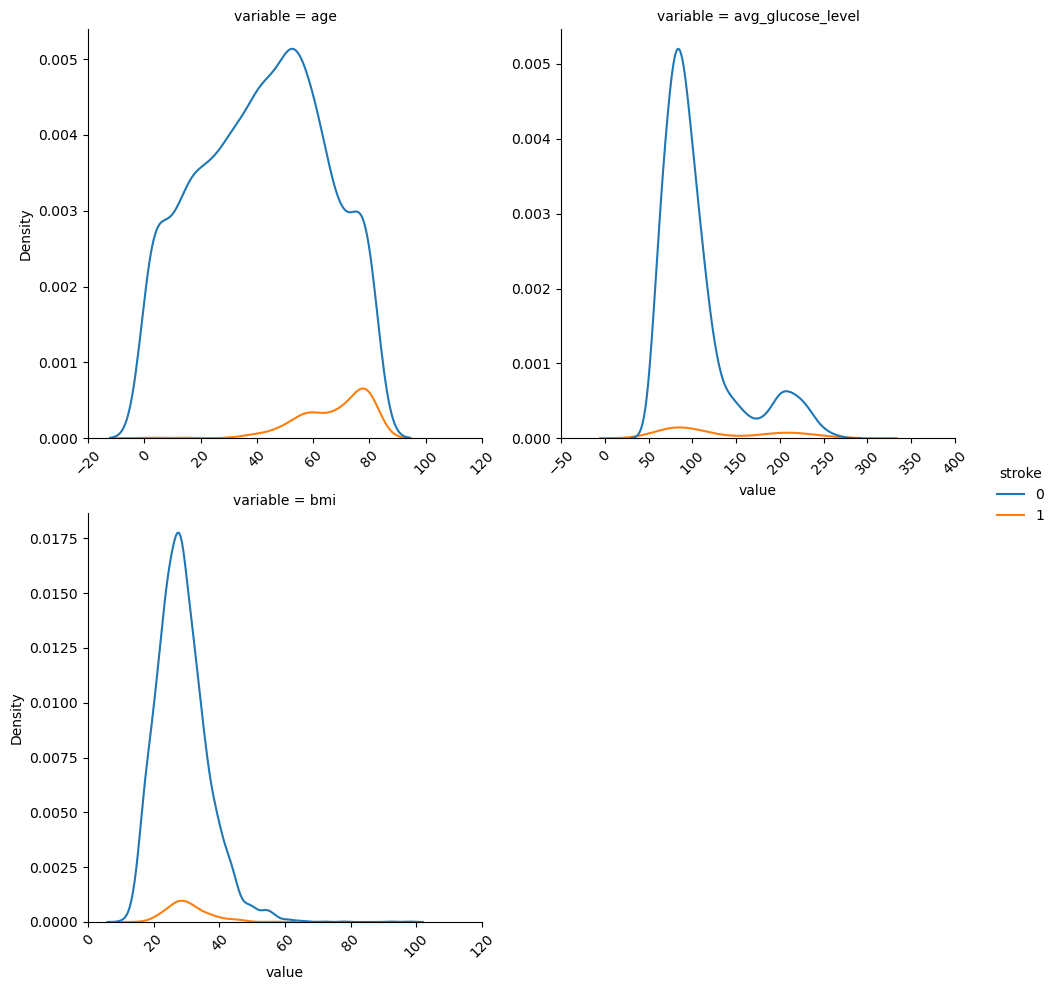

In [19]:
g=sns.displot(
    x='value',
    hue='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes(float)
    ),
    col='variable',
    kind='kde',
    col_wrap=2,
    facet_kws=dict(sharex=False, sharey=False)
)
g.set_xticklabels(rotation=45)
g.tight_layout();

Что интересного можного увидеть из этих графиков:
- по индексу **bmi** сколь значимого отличия нет, там и там максимум приходится примерно на 30
- по среднему уровню глюкозы в крови тоже не наблюдается отличий
- а вот по возрасту у пациентов с инсультом видно чёткое смещение пика к 80 годам

Как видим, какое-то чёткое разделение отсутствует. Рассмотрим парные графики

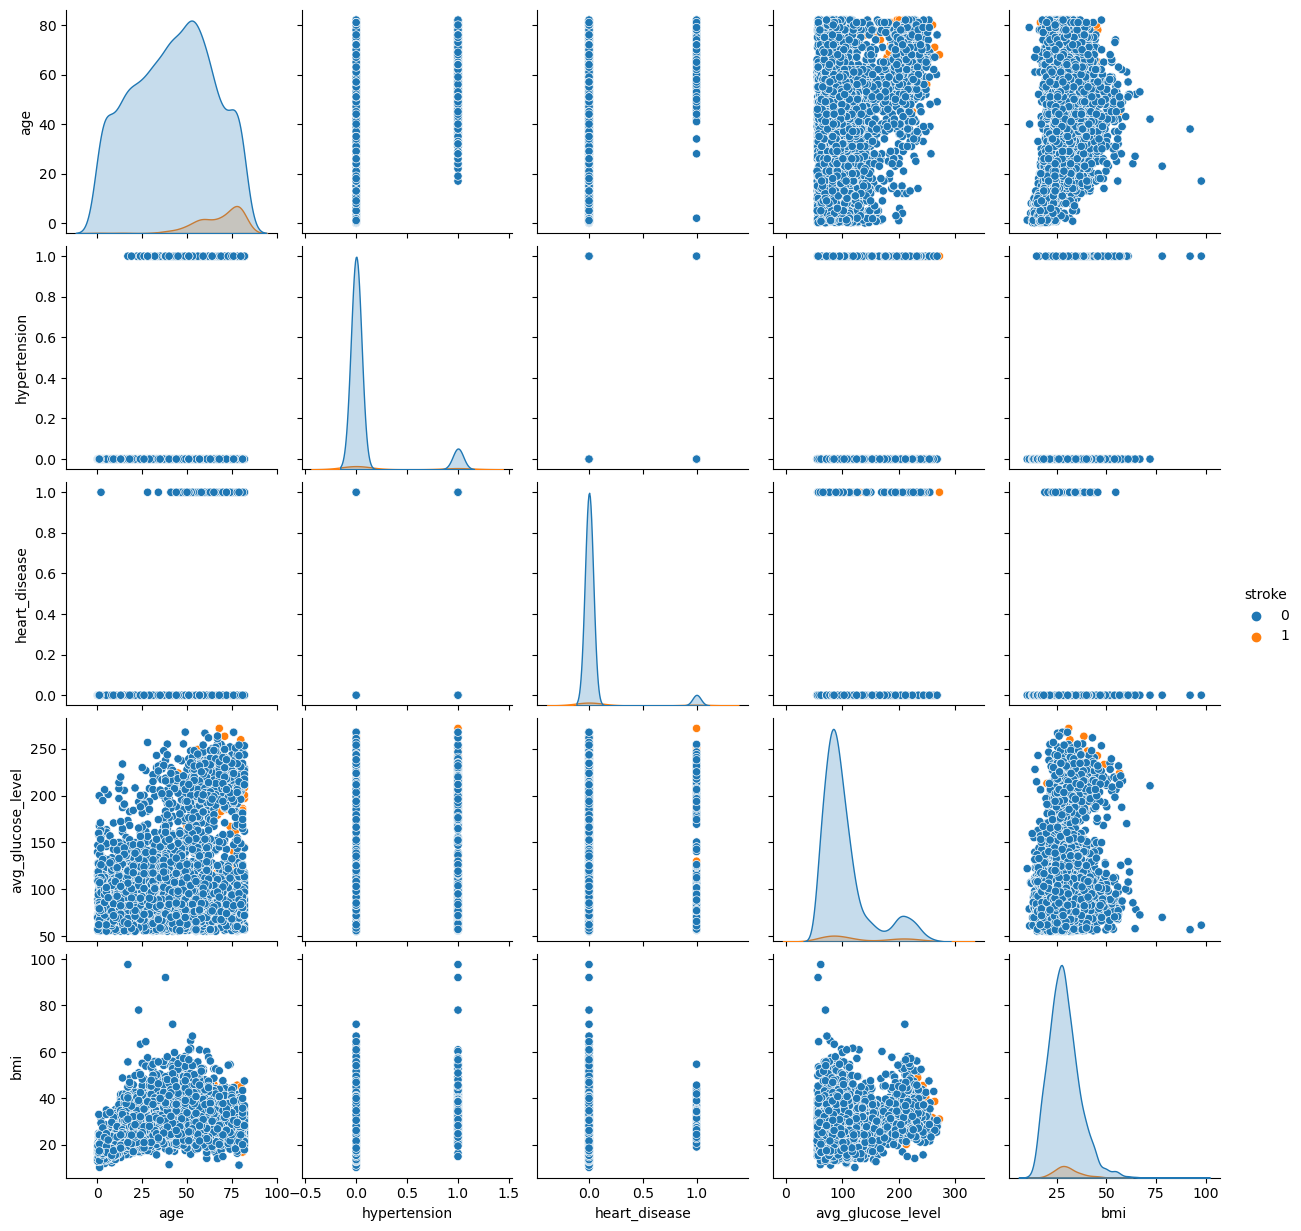

In [20]:
sns.pairplot(stroke, hue='stroke');

К сожалению разделение по целевому признаку видно плохо. Рассмотрим некоторые графики подробнее

In [21]:
def plot_stroke(x, y, alpha_1=0.2, alpha_2=0.5):
    plt.plot(stroke[stroke.stroke==0][x], stroke[stroke.stroke==0][y], 'bo', label='no stroke', alpha=alpha_1)
    plt.plot(stroke[stroke.stroke==1][x], stroke[stroke.stroke==1][y], 'r^', label='stroke', alpha=alpha_2)
    plt.grid(True, which='both')
    plt.legend(loc='center right', fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12, rotation=90);

Рассмотрим, как связаны возраст пациента, заболевания сердца и инсульт

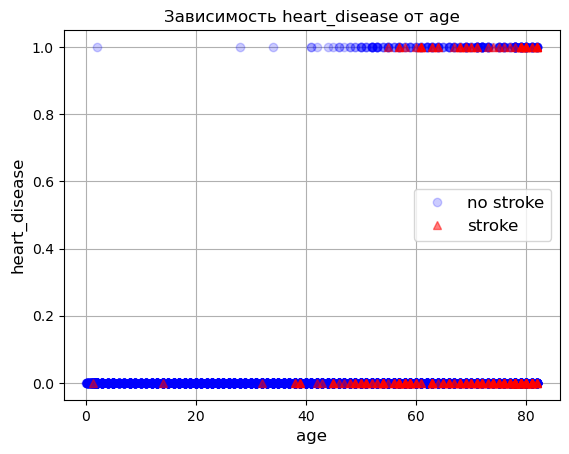

In [22]:
plot_stroke('age', 'heart_disease')
plt.title('Зависимость heart_disease от age');

Видна интересная особенность - у группы пациентов, у которых отсутствуют заболевания сердца, инсульт начинает встречаться с 40 лет! А у пациентов с заболеваниями сердца - ближе к 60 годам. 

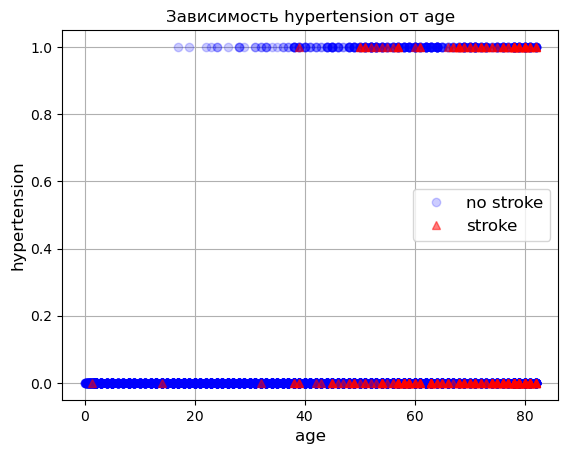

In [23]:
plot_stroke('age', 'hypertension')
plt.title('Зависимость hypertension от age');

Примерно схожая картина наблюдается у пациентов с гипертонией. Здесь также инсульт начинает проявляться примерно с 40 лет у здоровых пациентов, и с 50 лет у пациентов с гипертонией

Теперь рассмотрим как связаны между собой индекс массы тела, возраст и глюкоза в крови

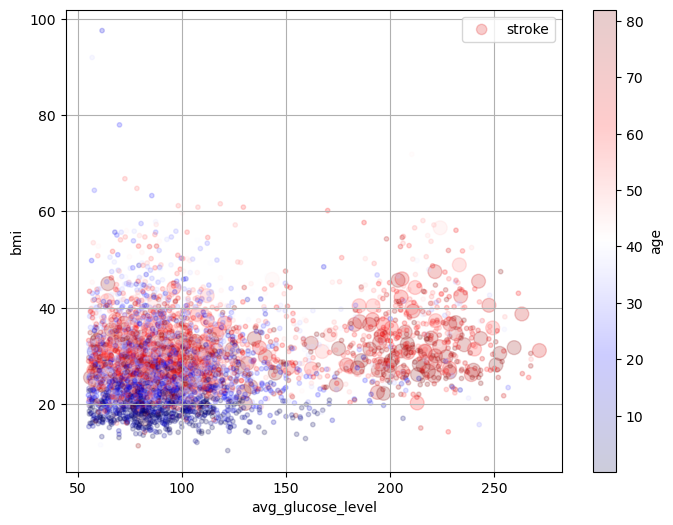

In [24]:
stroke.plot(
    kind='scatter', 
    x='avg_glucose_level', 
    y='bmi', 
    alpha=0.2,             
    label='stroke', 
    figsize=(8,6),
    c='age', 
    s=stroke.stroke.map(lambda x: 100 if x else 10),
    cmap='seismic',
    colorbar=True,
    grid=True,
    sharex=False)
plt.legend();

Отчётливо видно 2 скопления - левее и правее уровня глюкозы 150-170. Причём если справа в основном всё красное, то слева смесь и красного и синего цвета. Получается, что повышенный уровень глюкозы характерен для возраста старше 40 лет. Видно также небольшое повышение ИМТ с возрастом. При этом пациенты с инсультом есть и слева и справа.  

Если посмотреть только на пациентов с инсультом, то видно, что они в основном старше 50 лет и распределены примерно поровну по двум группам. При этом виден небольшой рост ИМТ.

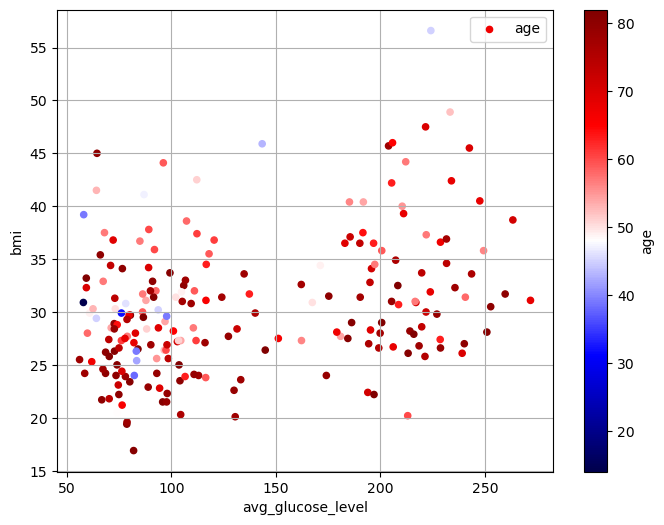

In [25]:
stroke[stroke.stroke==1].plot(
    kind='scatter', 
    x='avg_glucose_level', 
    y='bmi', 
    label='age', 
    figsize=(8,6),
    c='age', 
    cmap='seismic',
    colorbar=True,
    grid=True,
    sharex=False)
plt.legend();

И напоследок рассмотрим, как распределён инсульт по возрастным группам

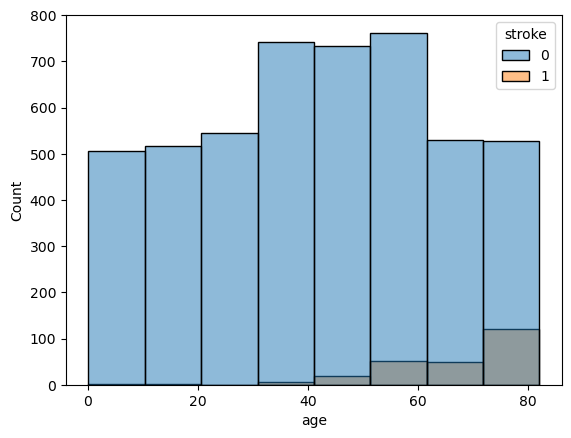

In [26]:
sns.histplot(
    x='age',
    data=stroke,
    hue='stroke',
    bins=8
);

Как видно, инсульт начинается проявляться после 40 лет, затем наблюдается рост после 50 лет, а потом после 70. При этом пациентов после 60 лет наблюдается меньше - то есть получается рост не только в абсолютных значениях, но и в относительных!

## 4. Подготовка данных (Data Preparation)

### 4.1 Получение базовых оценок

Для того, чтобы в дальнейшем понять, что мы движемся в верном направлении, получим базовые оценки на текущих данных. Но снаала вспомним, что категориальные признаки **gender**, **ever_married**, **Residence_type** имеют всего 2 варианта значений. Преобразуем их

In [27]:
stroke.gender = stroke.gender.map(lambda x: 1 if x == 'Male' else 0)

In [28]:
stroke.ever_married = stroke.ever_married.map(lambda x: 1 if x == 'Yes' else 0)

In [29]:
stroke.Residence_type = stroke.Residence_type.map(lambda x: 1 if x == 'Urban' else 0)

Разделим наш датасет на тестовый и тренировочный в соотношении 1/5. При этом стратифицируем выборку по целевому параметру, так как интересующих нас значений немного (примерно 5%)

In [30]:
stroke_train, stroke_test = train_test_split(stroke, test_size=0.2, random_state=42, stratify=stroke.stroke)

Также вспомним, что у признака **bmi** есть пропущенные значения. Заполним эти пропуски

In [31]:
stroke_train.bmi = stroke_train.bmi.fillna(stroke_train.bmi.mean())

Выделим метки

In [32]:
X_train = stroke_train.drop(['stroke'], axis=1)
y_train = stroke_train.stroke.copy()

In [33]:
cat_columns = X_train.select_dtypes(object).columns

In [34]:
num_columns = X_train.select_dtypes(exclude=object).columns

Закодируем категориальные значения и нормализуем числовые

In [35]:
prep = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=True, handle_unknown='ignore'), cat_columns),
    ('num', StandardScaler(), num_columns),
])

In [36]:
X_train_encoded = prep.fit_transform(X_train)

In [37]:
def make_scores(y_train, y_pred):
    scores = {
        'accuracy_score': f'{accuracy_score(y_train, y_pred):0.3f}',
        'precision_score': f'{precision_score(y_train, y_pred):0.3f}',
        'recall_score': f'{recall_score(y_train, y_pred):0.3f}',
        'f1_score': f'{f1_score(y_train, y_pred):0.3f}',
        'roc_auc': f'{roc_auc_score(y_train, y_pred):0.3f}'
    }
    return scores

Определим несколько классификаторов

In [38]:
sgd_clf = SGDClassifier(random_state=42, class_weight='balanced')
log_clf = LogisticRegression(random_state=42, class_weight='balanced')
svc_clf = LinearSVC(random_state=42, class_weight='balanced')
svm_clf = SVC(random_state=42, class_weight='balanced')
tre_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
rnd_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [39]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [42]:
metrics = {}
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ):
    y_train_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
    metrics[clf.__class__.__name__] = make_scores(y_train, y_train_pred)

In [43]:
pd.DataFrame(metrics).apply(pd.to_numeric).style.format('{:.3}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0)

,SGDClassifier,LogisticRegression,LinearSVC,SVC,DecisionTreeClassifier,RandomForestClassifier
accuracy_score,0.722,0.736,0.731,0.758,0.919,0.951
precision_score,0.109,0.131,0.131,0.115,0.174,0.25
recall_score,0.658,0.784,0.804,0.593,0.176,0.005
f1_score,0.187,0.224,0.225,0.192,0.175,0.01
roc_auc,0.692,0.759,0.766,0.679,0.567,0.502


Как видно, лучшие результаты дали **LogisticRegression** и **LinearSVC**

### 4.2 Feature engineering

Посмотрим, есть ли выбросы среди числовых признаков. Воспользуемся "ящиком с усами"

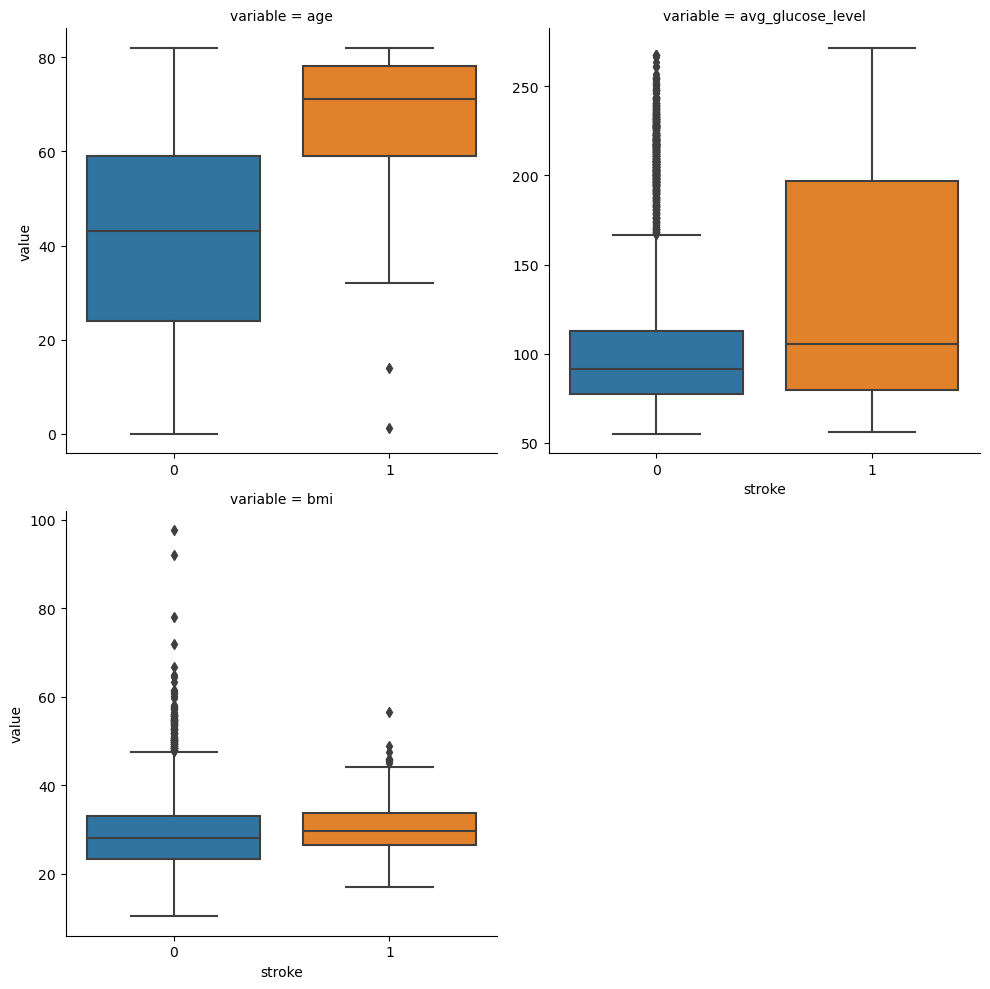

In [44]:
g=sns.catplot(
    y='value',
    x='stroke',
    data=stroke.melt(
        id_vars=['stroke'],
        value_vars=stroke.select_dtypes(float)
    ),
    col='variable',
    kind='box',
    col_wrap=2,
    sharex=False, 
    sharey=False,
)

Как видно, есть выбросы у **avg_glucose_level** и **bmi**. Определим функцию нахождения выбросов

In [45]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [46]:
boundaries = pd.DataFrame(calculate_outliers(X_train.select_dtypes(float)))
boundaries

,age,avg_glucose_level,bmi
0,-26.5,21.985,10.3
1,113.5,169.525,46.3


Удалим выбросы в **bmi**

In [47]:
#stroke_train.bmi[stroke_train.bmi > boundaries.bmi.max()] = boundaries.bmi.max()

Разделим всех наших пациентов на возрастные категории

In [48]:
stroke_train['age_category'] = pd.cut(stroke_train.age,
                                      bins=[0, 50, 60, 70, np.inf], 
                                      labels=[1, 2, 3, 4]).astype(int)
stroke_train[['age_category', 'stroke']].groupby(['age_category']).mean()

,stroke
age_category,
1,0.006318
2,0.067164
3,0.088608
4,0.170175


Как видно, после 50 лет и каждые последующие 10 лет увеличивается вероятность инсульта 

Создадим параметр, который показывает, курил ли когда-либо пациент

In [49]:
stroke_train['ever_smoking'] = stroke_train.apply(lambda x: 1 
                                                  if x.smoking_status in ['smokes', 'formerly smoked'] 
                                                  else 0, axis=1)
stroke_train[['ever_smoking', 'stroke']].groupby(['ever_smoking']).mean()

,stroke
ever_smoking,
0,0.039665
1,0.067164


Следующий признак показывает, есть ли у пациента сахарный диабет

In [50]:
stroke_train['diabeth'] = stroke_train.avg_glucose_level.map(lambda x: 1 if x>160 else 0)
stroke_train[['diabeth', 'stroke']].groupby(['diabeth']).mean()

,stroke
diabeth,
0,0.036056
1,0.131970


Как видно, вероятность инсульта с диабетом в 4 раза выше!

In [51]:
stroke_train[['hypertension', 'stroke']].groupby(['hypertension']).mean()

,stroke
hypertension,
0,0.039285
1,0.136020


Гипертензия увеличивает риск инсульта более чем в 4 раза 

In [52]:
stroke_train[['heart_disease', 'stroke']].groupby(['heart_disease']).mean()

,stroke
heart_disease,
0,0.042152
1,0.162896


Сердечные заболевания также увеличивают риск инсульта в 4 раза

Просуммируем негативные факторы, влияющие на риск возникновения инсульта

In [53]:
stroke_train['diseases'] = stroke_train.apply(lambda x: x.diabeth+x.hypertension+
                                              x.heart_disease+x.ever_smoking, axis=1)
stroke_train[['diseases', 'stroke']].groupby(['diseases']).mean()

,stroke
diseases,
0,0.022911
1,0.051852
2,0.144279
3,0.153061
4,0.416667


Как видно, у пациентов с "полным набором" вероятность инсульта 41,7%

Рассмотрим, как возраст и количество негативных факторов влияет на вероятность инсульта

In [54]:
stroke_train[['age_category', 'diseases', 'stroke']].groupby(['age_category', 'diseases']).mean()

stroke
age_category diseases          
1            0         0.003688
             1         0.007610
             2         0.046512
             3         0.000000
2            0         0.040146
             1         0.067416
             2         0.120000
             3         0.115385
             4         0.333333
3            0         0.040541
             1         0.080189
             2         0.129412
             3         0.222222
             4         1.000000
4            0         0.158192
             1         0.140187
             2         0.236641
             3         0.146341
             4         0.285714

Получается интересная картина: в третьей возрастной группе у пациентов с 4-мя негативными факторами вероятность инсульта 100%. А во второй группе 33%. При этом, в самой возрастной группе данная вероятность 28%.

Выведем корреляции признаков

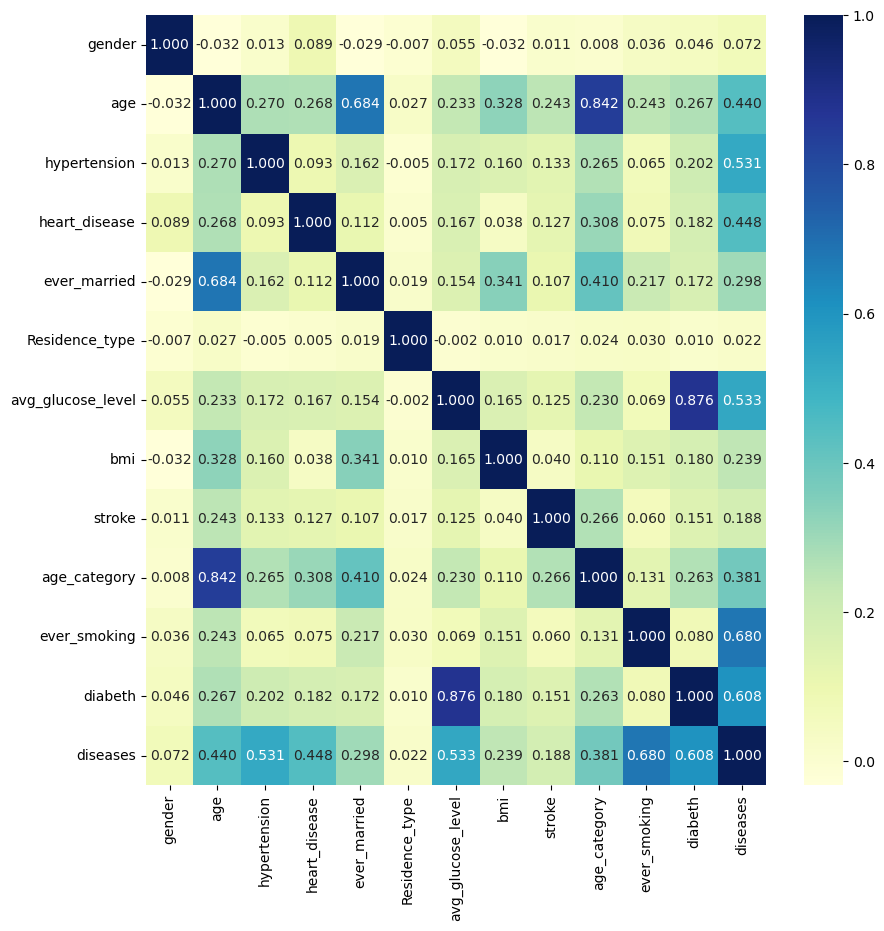

In [55]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    stroke_train.corr(), 
    annot=True, 
    cmap='YlGnBu',
    fmt='.3f',
);

In [56]:
stroke_train.corr()['stroke'].sort_values(ascending=False)

stroke               1.000000
age_category         0.265532
age                  0.243404
diseases             0.187933
diabeth              0.150675
hypertension         0.133109
heart_disease        0.126883
avg_glucose_level    0.125328
ever_married         0.106979
ever_smoking         0.059983
bmi                  0.039680
Residence_type       0.016559
gender               0.010697
Name: stroke, dtype: float64

Видим, что **gender** и **Residence_type** имеют слабую корреляцию. Удалим эти признаки

In [57]:
stroke_train = stroke_train.drop(['gender', 'Residence_type'], axis=1)

Снова выделим метки из тренировочного датасета

In [58]:
X_train = stroke_train.drop(['stroke'], axis=1)
y_train = stroke_train.stroke.copy()

In [59]:
cat_columns = X_train.select_dtypes(object).columns

In [60]:
num_columns = X_train.select_dtypes(exclude=object).columns

In [61]:
prep = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=True, handle_unknown='ignore'), cat_columns),
    ('num', StandardScaler(), num_columns),
])

In [62]:
X_train_encoded = prep.fit_transform(X_train)

In [63]:
metrics = {}
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ):
    y_train_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
    metrics[clf.__class__.__name__] = make_scores(y_train, y_train_pred)

In [64]:
pd.DataFrame(metrics).apply(pd.to_numeric).style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0)

,SGDClassifier,LogisticRegression,LinearSVC,SVC,DecisionTreeClassifier,RandomForestClassifier
accuracy_score,0.736,0.736,0.730,0.746,0.921,0.949
precision_score,0.120,0.135,0.132,0.121,0.181,0.133
recall_score,0.704,0.814,0.819,0.673,0.176,0.010
f1_score,0.206,0.231,0.228,0.205,0.179,0.019
roc_auc,0.720,0.773,0.772,0.712,0.568,0.503


Как видно, оценки заметно улучшились!

## 5. Моделирование

Попробуем потюнить наши модели. Для подбора гиперпараметров будем использовать _HyperOpt_. Определим несколько вспомогательных функций

In [65]:
def objective(params, model,  X_train, y_train):
    model.set_params(**params)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_train, y_train, method="predict", cv=skf, n_jobs=-1)
    score = roc_auc_score(y_train, y_pred)
    return   {'loss': -score, 'params': params, 'status': STATUS_OK}

In [66]:
def get_results(hp_results):
    results = pd.DataFrame([
        {**x, **{'loss_func' if k == 'loss' else k:v for k,v in x['params'].items()}} 
        for x in hp_results
    ])
    results.drop(['status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['loss'], ascending=True, inplace=True)
    return results

Зададим функцию комфортного отображения матрицы ошибок

In [67]:
def conf_matrix(y_test, y_pred):
    plt.figure(figsize = (4,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='PuBu')
    ax.set(xlabel='Predict', ylabel='True')

### 5.1 SGDClassifier

In [68]:
sgd_clf = SGDClassifier(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)

In [69]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : 'l1',
        'alpha': hp.uniform('alpha1', 1e-4, 1e-2),
        'early_stopping' : hp.choice('early_stopping1', [False, True]),
        'loss' : hp.choice('loss1', ['log', 'hinge', 'modified_huber', 'squared_hinge', 'huber']),
    },
    {
        'penalty' : 'l2',
        'alpha': hp.uniform('alpha2', 1e-6, 1e-3),
        'early_stopping' : hp.choice('early_stopping2', [False, True]),
        'loss' : hp.choice('loss2', ['log', 'hinge', 'modified_huber', 'squared_hinge', 'huber']),
    },
    {
        'penalty' : 'elasticnet',
        'l1_ratio': hp.uniform('l1_ratio', 0, 1),
        'alpha': hp.uniform('alpha3', 1e-4, 1e-2),
        'early_stopping' : hp.choice('early_stopping3', [False, True]),
        'loss' : hp.choice('loss3', ['log', 'hinge', 'modified_huber', 'squared_hinge', 'huber']),
    },
])

In [70]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=sgd_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:04<00:00, 20.89trial/s, best loss: -0.7773800863406775]


In [71]:
best

{'alpha': 0.009953155100371324,
 'early_stopping': True,
 'loss': 'log',
 'penalty': 'l1'}

In [72]:
result = get_results(trials.results)
result

,loss,alpha,early_stopping,loss_func,penalty,l1_ratio
39,-0.777380,0.009953,True,log,l1,NaN
35,-0.776609,0.009241,True,log,l1,NaN
74,-0.776609,0.009310,True,log,l1,NaN
66,-0.776609,0.009882,True,log,l1,NaN
44,-0.776609,0.009708,True,log,l1,NaN
...,...,...,...,...,...,...
8,-0.675008,0.000635,False,squared_hinge,l1,NaN
91,-0.670677,0.000849,False,modified_huber,l2,NaN
11,-0.670449,0.003147,True,squared_hinge,elasticnet,0.608152
85,-0.644879,0.000164,True,huber,l2,NaN


In [73]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.7773800863406775


За счёт подбора параметров, ROC_AUC удалось поднять на 5%

In [74]:
sgd_clf.set_params(**best)

SGDClassifier(alpha=0.009953155100371324, class_weight='balanced',
              early_stopping=True, l1_ratio=0.6755432273340097, loss='log',
              n_jobs=-1, penalty='l1', random_state=42)

In [75]:
sgd_clf.fit(X_train_encoded, y_train)

SGDClassifier(alpha=0.009953155100371324, class_weight='balanced',
              early_stopping=True, l1_ratio=0.6755432273340097, loss='log',
              n_jobs=-1, penalty='l1', random_state=42)

In [76]:
sorted(zip(sgd_clf.coef_[0], prep.get_feature_names_out()), reverse=True)

[(1.579997834505377, 'num__age'),
 (0.23873118659829937, 'num__diseases'),
 (0.17737300996674127, 'num__diabeth'),
 (0.0, 'num__hypertension'),
 (0.0, 'num__heart_disease'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'num__ever_married'),
 (0.0, 'num__bmi'),
 (0.0, 'num__avg_glucose_level'),
 (0.0, 'num__age_category'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Self-employed'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_formerly smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

Как видно, использовалось всего 3 признака

Посмотрим значение свободного члена

In [77]:
sgd_clf.intercept_

array([-1.15058507])

Посмотрим на значение ключевых метрик

In [78]:
y_pred = cross_val_predict(sgd_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
make_scores(y_train, y_pred)

{'accuracy_score': '0.740',
 'precision_score': '0.137',
 'recall_score': '0.819',
 'f1_score': '0.235',
 'roc_auc': '0.777'}

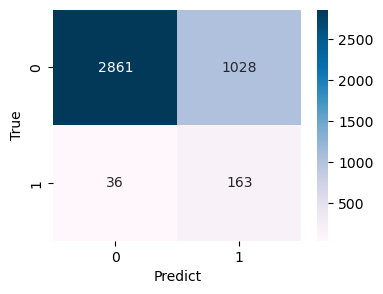

In [79]:
conf_matrix(y_train, y_pred)

### 5.2 Logistic Regression

In [82]:
log_clf = LogisticRegression(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1,
    tol = 1e-3
)

In [83]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : 'l1',
        'C': hp.uniform('C1', 1e-4, 1e2),
        'solver' : hp.choice('solver1', ['liblinear', 'saga']),
    },
    {
        'penalty' : 'l2',
        'C': hp.uniform('C2', 1e-4, 1e2),
        'solver' : hp.choice('solver2', ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']),
    },
    {
        'penalty' : 'none',
        'C': hp.uniform('C3', 1e-4, 1e2),
        'solver' : hp.choice('solver3', ['newton-cg', 'lbfgs', 'sag', 'saga']),
    },
    {
        'penalty' : 'elasticnet',
        'C': hp.uniform('C4', 1e-4, 1e2),
        'solver' : 'saga',
        'l1_ratio': hp.uniform('l1_ratio', 0, 1)
    },
])

In [84]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=log_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:15<00:00,  6.63trial/s, best loss: -0.7769833998999884]


In [85]:
best

{'C': 18.772624592124874,
 'l1_ratio': 0.1349255813367882,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [86]:
result = get_results(trials.results)
result

,loss,C,penalty,solver,l1_ratio
73,-0.776983,18.772625,elasticnet,saga,0.134926
0,-0.776678,62.011938,l1,saga,NaN
68,-0.776609,14.628933,elasticnet,saga,0.425050
87,-0.775837,3.943388,l2,saga,NaN
72,-0.775580,6.920241,elasticnet,saga,0.158325
...,...,...,...,...,...
88,-0.718423,99.448129,none,sag,NaN
40,-0.718423,57.503414,none,sag,NaN
6,-0.718423,99.698721,none,sag,NaN
47,-0.718423,69.124801,none,sag,NaN


In [87]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.7769833998999884


Результат сравнимый с полученным выше!

In [88]:
log_clf.set_params(**best)

LogisticRegression(C=18.772624592124874, class_weight='balanced',
                   l1_ratio=0.1349255813367882, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.001)

In [89]:
log_clf.fit(X_train_encoded, y_train)

LogisticRegression(C=18.772624592124874, class_weight='balanced',
                   l1_ratio=0.1349255813367882, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.001)

In [90]:
sorted(zip(log_clf.coef_[0], prep.get_feature_names_out()), reverse=True)

[(3.3593196514695514, 'num__age'),
 (2.1572250300979916, 'cat__work_type_children'),
 (0.37426796114375266, 'num__diabeth'),
 (0.18317601598725541, 'num__diseases'),
 (0.0863632804145618, 'num__hypertension'),
 (0.04824828493594658, 'num__bmi'),
 (0.0014709662173243035, 'num__heart_disease'),
 (-0.013161460922300592, 'num__ever_smoking'),
 (-0.053654043247686446, 'cat__smoking_status_smokes'),
 (-0.10095297392098103, 'cat__work_type_Never_worked'),
 (-0.13697121942070373, 'cat__smoking_status_Unknown'),
 (-0.14647917850915704, 'num__ever_married'),
 (-0.17151816315264265, 'cat__smoking_status_formerly smoked'),
 (-0.22280640493644846, 'num__avg_glucose_level'),
 (-0.3120963729479332, 'cat__smoking_status_never smoked'),
 (-0.8247455938547633, 'cat__work_type_Govt_job'),
 (-0.849895096176589, 'cat__work_type_Private'),
 (-0.9137315059698794, 'num__age_category'),
 (-1.0610613796975739, 'cat__work_type_Self-employed')]

In [91]:
log_clf.intercept_

array([-0.73842812])

Посмотрим на значение ключевых метрик

In [92]:
y_pred = cross_val_predict(log_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
make_scores(y_train, y_pred)

{'accuracy_score': '0.748',
 'precision_score': '0.140',
 'recall_score': '0.809',
 'f1_score': '0.238',
 'roc_auc': '0.777'}

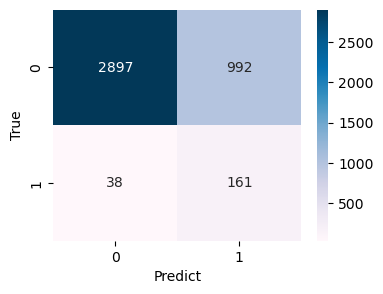

In [93]:
conf_matrix(y_train, y_pred)

### 5.3 LinearSVC

In [96]:
svc_clf = LinearSVC(random_state=42, class_weight='balanced')

In [97]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : 'l2',
        'C': hp.uniform('C2', 1e-6, 1e3),
        'loss' : hp.choice('loss1', ['hinge', 'squared_hinge']),
        'dual': True
    },
    {
        'penalty' : 'l1',
        'C': hp.uniform('C1', 1e-4, 1e2),
        'loss' : hp.choice('loss2', ['squared_hinge']),
        'dual': False
    }
])

In [98]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=svc_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:21<00:00,  4.76trial/s, best loss: -0.7766196629845035]


In [99]:
best

{'C': 0.04368171930101422,
 'dual': False,
 'loss': 'squared_hinge',
 'penalty': 'l1'}

In [100]:
result = get_results(trials.results)
result

,loss,C,dual,loss_func,penalty
74,-0.776620,0.043682,False,squared_hinge,l1
66,-0.776234,0.059465,False,squared_hinge,l1
93,-0.776105,0.061071,False,squared_hinge,l1
70,-0.774621,0.422290,False,squared_hinge,l1
67,-0.774493,0.518449,False,squared_hinge,l1
...,...,...,...,...,...
4,-0.517937,96.644647,True,squared_hinge,l2
36,-0.514770,339.971727,True,squared_hinge,l2
15,-0.514374,987.737212,True,squared_hinge,l2
41,-0.514374,999.879951,True,squared_hinge,l2


In [101]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.7766196629845035


Результат аналогичен ранее полученным

In [102]:
svc_clf.set_params(**best)

LinearSVC(C=0.04368171930101422, class_weight='balanced', dual=False,
          penalty='l1', random_state=42)

In [103]:
svc_clf.fit(X_train_encoded, y_train)

LinearSVC(C=0.04368171930101422, class_weight='balanced', dual=False,
          penalty='l1', random_state=42)

In [104]:
sorted(zip(svc_clf.coef_[0], prep.get_feature_names_out()), reverse=True)

[(0.7295832849185826, 'num__age'),
 (0.5054340738634641, 'cat__work_type_children'),
 (0.11632357458628814, 'num__diabeth'),
 (0.06444574149615223, 'num__diseases'),
 (0.028443591116338072, 'num__hypertension'),
 (0.002539449708710369, 'num__bmi'),
 (0.0021361001227390795, 'num__heart_disease'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_Unknown'),
 (-0.020632654526999975, 'cat__smoking_status_formerly smoked'),
 (-0.037742948325534875, 'num__age_category'),
 (-0.05610115105592385, 'num__ever_married'),
 (-0.058090776115028296, 'num__avg_glucose_level'),
 (-0.06084590071168652, 'cat__work_type_Self-employed'),
 (-0.06880049900768331, 'cat__smoking_status_never smoked')]

In [105]:
svc_clf.intercept_

array([-0.40294516])

Посмотрим на значение ключевых метрик

In [106]:
y_pred = cross_val_predict(svc_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
make_scores(y_train, y_pred)

{'accuracy_score': '0.729',
 'precision_score': '0.133',
 'recall_score': '0.829',
 'f1_score': '0.230',
 'roc_auc': '0.777'}

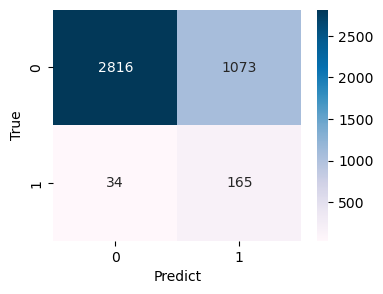

In [107]:
conf_matrix(y_train, y_pred)

### 5.4 SVC

In [110]:
svm_clf = SVC(random_state=42, class_weight='balanced')

Линейное ядро рассматривать не будем, полиномиальное тоже, так как это будет слишком медленно

In [111]:
param_grid = hp.choice('kernel',[
    {
        'kernel' : 'rbf',
        'C': hp.uniform('C1', 1e-2, 1e2),
        'gamma' : hp.uniform('gamma1', 0.01, 1),
    },
    {
        'kernel' : 'sigmoid',
        'C': hp.uniform('C2', 1e-2, 1e2),
        'coef0' : hp.uniform('coef0', 0, 1),
        'gamma' : hp.uniform('gamma2', 0.01, 1),
    },
])

In [112]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=svm_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:54<00:00,  1.84trial/s, best loss: -0.7380641960122029]


In [113]:
best

{'C': 2.68585005710284,
 'coef0': 0.6096569320003193,
 'gamma': 0.015397283182193177,
 'kernel': 'sigmoid'}

In [114]:
result = get_results(trials.results)
result

,loss,C,gamma,kernel,coef0
26,-0.738064,2.685850,0.015397,sigmoid,0.609657
68,-0.722989,84.217732,0.015372,sigmoid,0.171507
66,-0.722089,83.697137,0.013664,sigmoid,0.135776
22,-0.718805,82.655309,0.016930,sigmoid,0.238404
20,-0.712355,99.783900,0.011141,sigmoid,0.298499
...,...,...,...,...,...
41,-0.548763,44.485729,0.999881,rbf,NaN
50,-0.548635,59.714624,0.886437,rbf,NaN
7,-0.548635,74.806097,0.831789,rbf,NaN
15,-0.548576,20.436382,0.987860,rbf,NaN


In [115]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.7380641960122029


Удалось добиться прироста относительно базового показателя, но получилось в целом хуже, чем у других классификаторов

In [116]:
svm_clf.set_params(**best)

SVC(C=2.68585005710284, class_weight='balanced', coef0=0.6096569320003193,
    gamma=0.015397283182193177, kernel='sigmoid', random_state=42)

In [117]:
svm_clf.fit(X_train_encoded, y_train)

SVC(C=2.68585005710284, class_weight='balanced', coef0=0.6096569320003193,
    gamma=0.015397283182193177, kernel='sigmoid', random_state=42)

Посмотрим на значение ключевых метрик

In [118]:
y_pred = cross_val_predict(svm_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
make_scores(y_train, y_pred)

{'accuracy_score': '0.697',
 'precision_score': '0.115',
 'recall_score': '0.784',
 'f1_score': '0.201',
 'roc_auc': '0.738'}

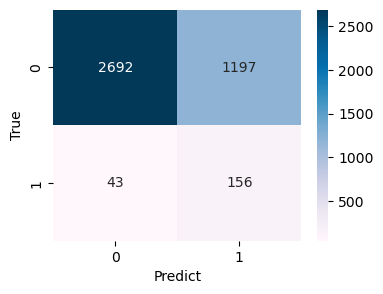

In [119]:
conf_matrix(y_train, y_pred)

По-прежнему хуже остальных

### 5.5 DecisionTreeClassifier

In [122]:
tre_clf = DecisionTreeClassifier(
    random_state=42, 
    class_weight='balanced'
)

In [123]:
param_grid = {
    'max_depth': hp.randint('max_depth', 1, 200),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 200),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 100),
    'min_samples_split': hp.randint('min_samples_split', 2, 100),
}

In [124]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=tre_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:02<00:00, 38.52trial/s, best loss: -0.7734532782193301]


In [125]:
best

{'max_depth': 29,
 'max_leaf_nodes': 87,
 'min_samples_leaf': 83,
 'min_samples_split': 19}

In [126]:
result = get_results(trials.results)
result

,loss,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split
70,-0.773453,29,156,83,37
73,-0.773453,82,67,83,65
72,-0.773453,113,103,83,57
69,-0.773453,113,16,83,19
68,-0.773453,29,87,83,19
...,...,...,...,...,...
7,-0.681918,166,158,7,48
92,-0.678354,176,122,9,37
32,-0.676812,83,71,13,3
10,-0.670865,9,106,4,8


In [127]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.7734532782193301


Точность улучшилась почти на 30%, относительно базовой оценки! Но в целом хуже

In [128]:
tre_clf.set_params(**best)

DecisionTreeClassifier(class_weight='balanced', max_depth=29, max_leaf_nodes=87,
                       min_samples_leaf=83, min_samples_split=19,
                       random_state=42)

In [129]:
tre_clf.fit(X_train_encoded, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=29, max_leaf_nodes=87,
                       min_samples_leaf=83, min_samples_split=19,
                       random_state=42)

In [378]:
sorted(zip(tre_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.8211553765388782, 'num__age'),
 (0.08263564324304142, 'num__diseases'),
 (0.06051045591425783, 'num__bmi'),
 (0.019867007143764617, 'num__avg_glucose_level'),
 (0.007841495111611575, 'cat__smoking_status_formerly smoked'),
 (0.004507382005517296, 'num__age_category'),
 (0.003482640042929153, 'cat__work_type_Private'),
 (0.0, 'num__hypertension'),
 (0.0, 'num__heart_disease'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'num__ever_married'),
 (0.0, 'num__diabeth'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Self-employed'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

Посмотрим на значение ключевых метрик

In [131]:
y_pred = cross_val_predict(tre_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
make_scores(y_train, y_pred)

{'accuracy_score': '0.737',
 'precision_score': '0.135',
 'recall_score': '0.814',
 'f1_score': '0.231',
 'roc_auc': '0.773'}

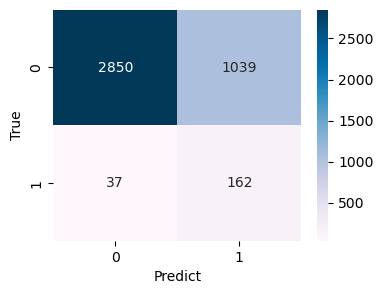

In [132]:
conf_matrix(y_train, y_pred)

### 5.6 RandomForestClassifier

In [135]:
rnd_clf = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True
)

In [136]:
param_grid = {
    'max_depth': hp.randint('max_depth', 1, 100),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 100),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 100),
    'min_samples_split': hp.randint('min_samples_split', 2, 100),
    'n_estimators': hp.randint('n_estimators', 100, 1000),
    'max_samples': hp.uniform('max_samples', 0, 1),
}

In [137]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=rnd_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [04:20<00:00,  2.60s/trial, best loss: -0.7822398182736774]


In [138]:
best

{'max_depth': 34,
 'max_leaf_nodes': 62,
 'max_samples': 0.8839266254726155,
 'min_samples_leaf': 65,
 'min_samples_split': 81,
 'n_estimators': 125}

In [139]:
result = get_results(trials.results)
result

,loss,max_depth,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators
0,-0.782240,34,62,0.883927,65,81,125
7,-0.778405,47,83,0.748036,79,8,529
16,-0.778030,69,81,0.816995,90,88,717
61,-0.777894,20,39,0.671225,42,76,973
23,-0.777564,81,83,0.902963,80,67,125
...,...,...,...,...,...,...,...
39,-0.743681,19,24,0.860397,5,12,615
25,-0.736074,88,78,0.689237,2,68,177
50,-0.713931,58,76,0.790473,11,7,591
14,-0.555368,85,90,0.017097,1,24,585


In [140]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.7822398182736774


Лучше, чем у **DecisionTreeClassifier**!

In [141]:
rnd_clf.set_params(**best)

RandomForestClassifier(class_weight='balanced', max_depth=34, max_leaf_nodes=62,
                       max_samples=0.8839266254726155, min_samples_leaf=65,
                       min_samples_split=81, n_estimators=125, n_jobs=-1,
                       oob_score=True, random_state=42)

In [142]:
rnd_clf.fit(X_train_encoded, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=34, max_leaf_nodes=62,
                       max_samples=0.8839266254726155, min_samples_leaf=65,
                       min_samples_split=81, n_estimators=125, n_jobs=-1,
                       oob_score=True, random_state=42)

Давайте посмотрим, какую точность мы имеем на неиспользуемом наборе данных (oob)

In [143]:
rnd_clf.oob_score_

0.7284735812133072

In [144]:
sorted(zip(rnd_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.38756287826467645, 'num__age'),
 (0.25730491461999183, 'num__age_category'),
 (0.07040503712785322, 'num__avg_glucose_level'),
 (0.07000743753640748, 'num__bmi'),
 (0.06958447423501778, 'num__diseases'),
 (0.03935729765431519, 'num__ever_married'),
 (0.02776652459864016, 'num__diabeth'),
 (0.022078655711960344, 'cat__work_type_children'),
 (0.013174149459638965, 'num__hypertension'),
 (0.005986308401310909, 'num__heart_disease'),
 (0.005751789229513912, 'cat__smoking_status_formerly smoked'),
 (0.005320327925814005, 'cat__smoking_status_smokes'),
 (0.005289752215061556, 'cat__smoking_status_never smoked'),
 (0.0051750871734749715, 'cat__work_type_Private'),
 (0.005111697107250527, 'cat__smoking_status_Unknown'),
 (0.004637255989751899, 'num__ever_smoking'),
 (0.004437909459890765, 'cat__work_type_Self-employed'),
 (0.001048503289430081, 'cat__work_type_Govt_job'),
 (0.0, 'cat__work_type_Never_worked')]

Посмотрим на значение ключевых метрик

In [145]:
y_pred = cross_val_predict(rnd_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
make_scores(y_train, y_pred)

{'accuracy_score': '0.717',
 'precision_score': '0.131',
 'recall_score': '0.854',
 'f1_score': '0.227',
 'roc_auc': '0.782'}

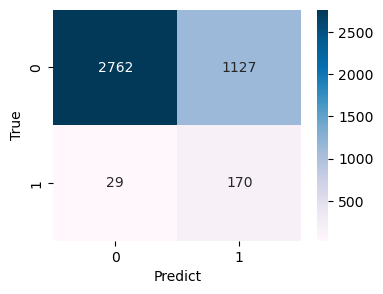

In [146]:
conf_matrix(y_train, y_pred)

Теперь сравним еще раз полученные значения

In [149]:
metrics_new = {}
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ):
    y_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
    metrics_new[clf.__class__.__name__] = make_scores(y_train, y_pred)

In [150]:
(pd.DataFrame(metrics_new).apply(pd.to_numeric)
 .style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0))

,SGDClassifier,LogisticRegression,LinearSVC,SVC,DecisionTreeClassifier,RandomForestClassifier
accuracy_score,0.740,0.748,0.729,0.697,0.737,0.717
precision_score,0.137,0.140,0.133,0.115,0.135,0.131
recall_score,0.819,0.809,0.829,0.784,0.814,0.854
f1_score,0.235,0.238,0.230,0.201,0.231,0.227
roc_auc,0.777,0.777,0.777,0.738,0.773,0.782


Оценим, как изменились наши показатели после тюнинга моделей

In [151]:
def diff_metrics(a, b):
    a1 = pd.DataFrame(a).apply(pd.to_numeric)
    b1 = pd.DataFrame(b).apply(pd.to_numeric)
    columns = a.keys()
    index = list(a.values())[0].keys()
    diff = pd.DataFrame((a1.values - b1.values)/b1.values*100, columns=columns, index=index)
    return diff.T.style.format('{:.2f}').background_gradient(cmap=plt.get_cmap('coolwarm'), axis=None, vmin=-10, vmax=10)

Отобразим прирост метрик в процентах

In [152]:
diff_metrics(metrics_new, metrics)

,accuracy_score,precision_score,recall_score,f1_score,roc_auc
SGDClassifier,0.54,14.17,16.34,14.08,7.92
LogisticRegression,1.63,3.70,-0.61,3.03,0.52
LinearSVC,-0.14,0.76,1.22,0.88,0.65
SVC,-6.57,-4.96,16.49,-1.95,3.65
DecisionTreeClassifier,-19.98,-25.41,362.50,29.05,36.09
RandomForestClassifier,-24.45,-1.50,8440.00,1094.74,55.47


В целом видим прирост метрик ROC_AUC по всем моделям! Но самый колоссальный прирост показал случайный лес! Не будем останавливаться на этом и протестируем еще кое-какие модели

### 5.7 AdaBoostClasifier

Теперь попробуем бустинги! Начнём с адаптивного бустинга. Пробуем классификатор на "пеньках"

In [153]:
ada_clf = AdaBoostClassifier(random_state=42)

In [154]:
ada_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [155]:
param_grid = {
    'n_estimators': hp.randint('n_estimators', 50, 500),
    'learning_rate': hp.uniform('learning_rate', 0.01, 10),
}

In [156]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=ada_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [01:56<00:00,  1.16s/trial, best loss: -0.6629909640772648]


In [157]:
best

{'learning_rate': 2.0698833507083014, 'n_estimators': 270}

In [158]:
result = get_results(trials.results)
result

,loss,learning_rate,n_estimators
50,-0.662991,2.069883,270
49,-0.658234,2.029159,136
55,-0.618705,2.143758,150
75,-0.574092,2.269885,302
48,-0.568762,2.674948,274
...,...,...,...
69,-0.499871,2.471769,153
70,-0.499743,0.046446,467
3,-0.497300,2.130049,333
60,-0.497300,2.114616,151


In [159]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.6629909640772648


Очень слабо!

In [160]:
ada_clf.set_params(**best)

AdaBoostClassifier(learning_rate=2.0698833507083014, n_estimators=270,
                   random_state=42)

In [161]:
ada_clf.fit(X_train_encoded, y_train)

AdaBoostClassifier(learning_rate=2.0698833507083014, n_estimators=270,
                   random_state=42)

In [162]:
sorted(zip(ada_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.9111111111111111, 'cat__work_type_children'),
 (0.08888888888888889, 'num__age'),
 (0.0, 'num__hypertension'),
 (0.0, 'num__heart_disease'),
 (0.0, 'num__ever_smoking'),
 (0.0, 'num__ever_married'),
 (0.0, 'num__diseases'),
 (0.0, 'num__diabeth'),
 (0.0, 'num__bmi'),
 (0.0, 'num__avg_glucose_level'),
 (0.0, 'num__age_category'),
 (0.0, 'cat__work_type_Self-employed'),
 (0.0, 'cat__work_type_Private'),
 (0.0, 'cat__work_type_Never_worked'),
 (0.0, 'cat__work_type_Govt_job'),
 (0.0, 'cat__smoking_status_smokes'),
 (0.0, 'cat__smoking_status_never smoked'),
 (0.0, 'cat__smoking_status_formerly smoked'),
 (0.0, 'cat__smoking_status_Unknown')]

Как видно, данная модель отдала предпочтение параметру **work_type_children**. Как видно, не лучшее решение

Попробуем подогнать параметры базового оценщика

In [163]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'), random_state=42)

In [164]:
param_grid = {
    'base_estimator__max_depth': hp.randint('max_depth', 1, 200),
    'base_estimator__max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 200),
    'base_estimator__min_samples_leaf': hp.randint('min_samples_leaf', 1, 100),
    'base_estimator__min_samples_split': hp.randint('min_samples_split', 2, 100),
    'n_estimators': hp.randint('n_estimators', 50, 500),
    'learning_rate': hp.uniform('learning_rate', 0.01, 10),
}

In [165]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=ada_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [02:51<00:00,  1.71s/trial, best loss: -0.762840946827219]


In [166]:
best

{'base_estimator__max_depth': 35,
 'base_estimator__max_leaf_nodes': 154,
 'base_estimator__min_samples_leaf': 34,
 'base_estimator__min_samples_split': 72,
 'learning_rate': 5.738875084480478,
 'n_estimators': 63}

In [167]:
result = get_results(trials.results)
result

,loss,base_estimator__max_depth,base_estimator__max_leaf_nodes,base_estimator__min_samples_leaf,base_estimator__min_samples_split,learning_rate,n_estimators
8,-0.762841,35,154,34,72,5.738875,63
87,-0.754480,44,186,77,15,4.560275,493
88,-0.750021,65,120,77,96,2.487447,493
94,-0.747659,158,120,69,96,2.546598,493
85,-0.746994,17,117,42,38,4.652837,63
...,...,...,...,...,...,...,...
49,-0.484332,116,17,24,83,5.655863,136
82,-0.470190,146,189,93,48,7.904941,422
10,-0.415534,178,10,53,5,9.548257,78
66,-0.324970,107,6,66,65,5.931578,152


In [168]:
ada_clf.set_params(**best)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=35,
                                                         max_leaf_nodes=154,
                                                         min_samples_leaf=34,
                                                         min_samples_split=72),
                   learning_rate=5.738875084480478, n_estimators=63,
                   random_state=42)

In [169]:
ada_clf.fit(X_train_encoded, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=35,
                                                         max_leaf_nodes=154,
                                                         min_samples_leaf=34,
                                                         min_samples_split=72),
                   learning_rate=5.738875084480478, n_estimators=63,
                   random_state=42)

In [170]:
sorted(zip(ada_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.9728749497611466, 'num__age'),
 (0.0018421362037886278, 'num__avg_glucose_level'),
 (6.0132975190036416e-05, 'cat__smoking_status_never smoked'),
 (5.826395969644913e-07, 'cat__work_type_Self-employed'),
 (nan, 'num__bmi'),
 (0.0015826533474984476, 'num__diseases'),
 (0.0003151070386751353, 'num__age_category'),
 (0.00011749622851610014, 'cat__smoking_status_formerly smoked'),
 (6.160736189623387e-05, 'cat__work_type_Private'),
 (5.26665064673951e-05, 'cat__work_type_Govt_job'),
 (1.9502332291909045e-08, 'num__ever_smoking'),
 (4.518911067843497e-11, 'num__ever_married'),
 (1.5063050109752887e-11, 'num__diabeth'),
 (1.5063037328880455e-11, 'cat__smoking_status_smokes'),
 (1.506303689281166e-11, 'num__hypertension'),
 (2.4118837278460584e-17, 'num__heart_disease'),
 (4.929608271228742e-19, 'cat__smoking_status_Unknown'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Never_worked')]

Посмотрим на значение ключевых метрик

In [171]:
y_pred = cross_val_predict(ada_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
make_scores(y_train, y_pred)

{'accuracy_score': '0.721',
 'precision_score': '0.127',
 'recall_score': '0.809',
 'f1_score': '0.220',
 'roc_auc': '0.763'}

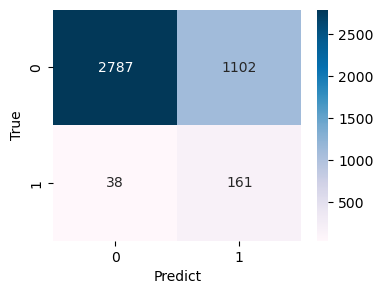

In [172]:
conf_matrix(y_train, y_pred)

### 5.8 GradientBoostingClassifier

Теперь попробуем градиентный бустинг

In [175]:
gbt_clf = GradientBoostingClassifier(random_state=42)

In [176]:
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 5),
    'max_depth': hp.randint('max_depth', 3, 50),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 50),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 50),
    'min_samples_split': hp.randint('min_samples_split', 2, 50),
    'n_estimators': hp.randint('n_estimators', 100, 500),
    'subsample': hp.uniform('subsample', 0.1, 0.9),
}

In [177]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=gbt_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [02:46<00:00,  1.67s/trial, best loss: -0.6541281878665633]


In [178]:
best

{'learning_rate': 4.0458294904593215,
 'max_depth': 17,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 10,
 'min_samples_split': 37,
 'n_estimators': 235,
 'subsample': 0.3265287504240839}

In [179]:
result = get_results(trials.results)
result

,loss,learning_rate,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,n_estimators,subsample
12,-0.654128,4.045829,17,31,10,37,235,0.326529
93,-0.650389,4.823160,37,47,38,28,424,0.438159
9,-0.629837,3.267321,22,22,38,25,289,0.360026
56,-0.626945,4.168871,4,5,38,34,449,0.291178
97,-0.622273,4.006801,39,47,49,40,228,0.552943
...,...,...,...,...,...,...,...,...
54,-0.406838,2.496542,47,43,25,48,260,0.882719
21,-0.405817,3.484901,22,31,29,25,470,0.570917
65,-0.405479,4.147063,4,14,38,34,382,0.282297
88,-0.384347,3.870744,34,27,8,17,450,0.170314


In [180]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.6541281878665633


In [181]:
gbt_clf.set_params(**best)

GradientBoostingClassifier(learning_rate=4.0458294904593215, max_depth=17,
                           max_leaf_nodes=31, min_samples_leaf=10,
                           min_samples_split=37, n_estimators=235,
                           random_state=42, subsample=0.3265287504240839)

In [182]:
gbt_clf.fit(X_train_encoded, y_train)

GradientBoostingClassifier(learning_rate=4.0458294904593215, max_depth=17,
                           max_leaf_nodes=31, min_samples_leaf=10,
                           min_samples_split=37, n_estimators=235,
                           random_state=42, subsample=0.3265287504240839)

In [183]:
sorted(zip(gbt_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.680862715741691, 'num__age'),
 (0.15722596878588097, 'num__avg_glucose_level'),
 (0.04612418948491779, 'num__bmi'),
 (0.044085305444177526, 'num__age_category'),
 (0.04379362064033516, 'cat__smoking_status_formerly smoked'),
 (0.014697533449064378, 'num__diseases'),
 (0.005774955325239424, 'num__diabeth'),
 (0.002370224651095006, 'cat__smoking_status_never smoked'),
 (0.001116980155106293, 'cat__smoking_status_Unknown'),
 (0.0008290405348450485, 'cat__work_type_Private'),
 (0.0007732822294657855, 'num__hypertension'),
 (0.0006375524908139508, 'num__heart_disease'),
 (0.0005115876130766605, 'num__ever_smoking'),
 (0.000447300887076825, 'num__ever_married'),
 (0.0003524581223217665, 'cat__smoking_status_smokes'),
 (0.0003282985392685991, 'cat__work_type_Self-employed'),
 (6.898590562383095e-05, 'cat__work_type_Govt_job'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Never_worked')]

Посмотрим на значение ключевых метрик

In [184]:
y_pred = cross_val_predict(gbt_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
make_scores(y_train, y_pred)

{'accuracy_score': '0.628',
 'precision_score': '0.085',
 'recall_score': '0.683',
 'f1_score': '0.152',
 'roc_auc': '0.654'}

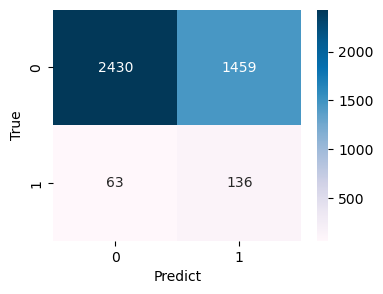

In [185]:
conf_matrix(y_train, y_pred)

### 5.9 XGBoostClassifier

Попробуем экстемальный градиентный бустинг

In [188]:
xgb_clf = XGBClassifier(
    random_state=42, 
    verbosity=0, 
    scale_pos_weight=33,
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    n_jobs=-1,
    n_estimators=200, 
    booster='gbtree',
)

In [189]:
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 5),
    'min_split_loss': hp.uniform('min_split_loss', 0, 100),
    'max_depth': hp.randint('max_depth', 1, 100),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
}

In [190]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=xgb_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:21<00:00,  4.72trial/s, best loss: -0.778720679768087]


In [191]:
best

{'learning_rate': 0.07745633903552444,
 'max_depth': 44,
 'min_split_loss': 37.779732538227684,
 'subsample': 0.7843910552422412}

In [192]:
result = get_results(trials.results)
result

,loss,learning_rate,max_depth,min_split_loss,subsample
92,-0.778721,0.077456,44,37.779733,0.784391
24,-0.775543,0.038420,44,28.263260,0.895851
97,-0.774338,0.117226,26,41.946620,0.724310
74,-0.770004,0.167871,31,40.113237,0.707548
65,-0.769989,0.010273,31,39.673059,0.874991
...,...,...,...,...,...
90,-0.497864,3.552344,2,47.169053,0.799257
17,-0.477065,4.882861,86,10.308207,0.629980
55,-0.447473,4.577159,56,35.859148,0.690155
13,-0.447035,4.411678,63,46.714857,0.526969


In [193]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.778720679768087


Результат оказался хуже, чем у обычного градиентного бустинга

In [194]:
xgb_clf.set_params(**best)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07745633903552444,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=44, max_leaves=None,
              min_child_weight=None, min_split_loss=37.779732538227684,
              missing=nan, monotone_constraints=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, predictor=None, ...)

In [195]:
xgb_clf.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=37.7797318,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.07745633903552444,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=44, max_leaves=0, min_child_weight=1,
              min_split_loss=37.779732538227684, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', ...)

In [196]:
sorted(zip(xgb_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(0.20523627, 'num__age'),
 (0.078146555, 'num__ever_smoking'),
 (0.061493885, 'cat__smoking_status_never smoked'),
 (0.05746197, 'num__hypertension'),
 (0.05641628, 'num__diseases'),
 (0.056275617, 'cat__smoking_status_Unknown'),
 (0.053489823, 'num__ever_married'),
 (0.05319067, 'num__bmi'),
 (0.05228812, 'num__avg_glucose_level'),
 (0.050615486, 'num__diabeth'),
 (0.05057493, 'cat__work_type_Self-employed'),
 (0.050568134, 'cat__smoking_status_smokes'),
 (0.04717829, 'cat__smoking_status_formerly smoked'),
 (0.04476649, 'cat__work_type_Private'),
 (0.04278014, 'num__heart_disease'),
 (0.039517295, 'cat__work_type_Govt_job'),
 (0.0, 'num__age_category'),
 (0.0, 'cat__work_type_children'),
 (0.0, 'cat__work_type_Never_worked')]

Посмотрим на значение ключевых метрик

In [197]:
y_pred = cross_val_predict(xgb_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
make_scores(y_train, y_pred)

{'accuracy_score': '0.697',
 'precision_score': '0.125',
 'recall_score': '0.869',
 'f1_score': '0.218',
 'roc_auc': '0.779'}

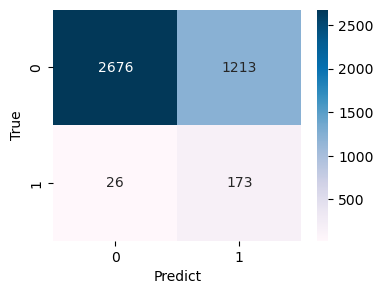

In [198]:
conf_matrix(y_train, y_pred)

### 5.10 CatBoostClassifier

In [201]:
cat_clf = CatBoostClassifier(logging_level='Silent', random_state=42)

In [202]:
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hp.randint('depth', 4, 10),
    'l2_leaf_reg': hp.randint('l2_leaf_reg', 1, 9),
}

In [203]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=cat_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [10:17<00:00,  6.18s/trial, best loss: -0.5315171899611195]


In [204]:
best

{'depth': 6, 'l2_leaf_reg': 6, 'learning_rate': 0.09475260049203021}

In [205]:
result = get_results(trials.results)
result

,loss,depth,l2_leaf_reg,learning_rate
33,-0.531517,6,6,0.094753
75,-0.531131,5,2,0.082214
67,-0.529390,6,7,0.087013
35,-0.529390,6,2,0.083751
65,-0.527649,6,7,0.078513
...,...,...,...,...
7,-0.507993,8,7,0.015786
13,-0.507993,6,6,0.016068
51,-0.506509,6,7,0.010117
2,-0.502197,4,3,0.023227


In [206]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.5315171899611195


In [207]:
cat_clf.set_params(**best)

In [208]:
cat_clf.fit(X_train_encoded, y_train, logging_level='Silent')

Посмотрим на значение ключевых метрик

In [209]:
y_pred = cross_val_predict(cat_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="predict")
make_scores(y_train, y_pred)

{'accuracy_score': '0.943',
 'precision_score': '0.238',
 'recall_score': '0.075',
 'f1_score': '0.115',
 'roc_auc': '0.532'}

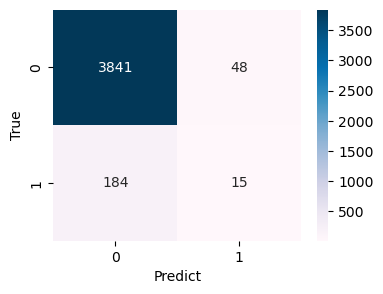

In [210]:
conf_matrix(y_train, y_pred)

### 5.11 LGBMClassifier

In [213]:
lgb_clf = LGBMClassifier(
    boosting='gbdt',
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)

In [214]:
param_grid = {
    'num_leaves': hp.randint('num_leaves', 10, 50),
    'max_depth': hp.randint('max_depth', 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'subsample': hp.uniform('subsample', 0.2, 0.9),
    'subsample_freq': hp.randint('subsample_freq', 1, 50),
}

In [215]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=lgb_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [00:25<00:00,  3.90trial/s, best loss: -0.7768987648450533]


In [216]:
best

{'learning_rate': 0.09264161655158663,
 'max_depth': 1,
 'num_leaves': 23,
 'subsample': 0.37750632130522427,
 'subsample_freq': 40}

In [217]:
result = get_results(trials.results)
result

,loss,learning_rate,max_depth,num_leaves,subsample,subsample_freq
61,-0.776899,0.092642,1,23,0.377506,40
66,-0.773358,0.083751,1,23,0.378918,40
59,-0.765354,0.085032,1,23,0.322220,13
68,-0.762466,0.099598,1,38,0.438574,17
80,-0.761754,0.072394,1,25,0.276252,40
...,...,...,...,...,...,...
64,-0.555728,0.091338,17,23,0.297299,42
45,-0.552668,0.089640,20,48,0.762229,15
72,-0.552058,0.073939,11,31,0.467451,35
0,-0.549454,0.068657,23,42,0.634083,2


In [218]:
print(f'Лучшая оценка ROC_AUC = {-result.loss.min()}')

Лучшая оценка ROC_AUC = 0.7768987648450533


In [219]:
lgb_clf.set_params(**best)

LGBMClassifier(boosting='gbdt', class_weight='balanced',
               learning_rate=0.09264161655158663, max_depth=1, n_estimators=200,
               num_leaves=23, random_state=42, subsample=0.37750632130522427,
               subsample_freq=40)

In [220]:
lgb_clf.fit(X_train_encoded, y_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(boosting='gbdt', class_weight='balanced',
               learning_rate=0.09264161655158663, max_depth=1, n_estimators=200,
               num_leaves=23, random_state=42, subsample=0.37750632130522427,
               subsample_freq=40)

In [221]:
sorted(zip(lgb_clf.feature_importances_, prep.get_feature_names_out()), reverse=True)

[(97, 'num__age'),
 (56, 'num__bmi'),
 (27, 'num__avg_glucose_level'),
 (14, 'num__diseases'),
 (6, 'num__ever_married'),
 (0, 'num__hypertension'),
 (0, 'num__heart_disease'),
 (0, 'num__ever_smoking'),
 (0, 'num__diabeth'),
 (0, 'num__age_category'),
 (0, 'cat__work_type_children'),
 (0, 'cat__work_type_Self-employed'),
 (0, 'cat__work_type_Private'),
 (0, 'cat__work_type_Never_worked'),
 (0, 'cat__work_type_Govt_job'),
 (0, 'cat__smoking_status_smokes'),
 (0, 'cat__smoking_status_never smoked'),
 (0, 'cat__smoking_status_formerly smoked'),
 (0, 'cat__smoking_status_Unknown')]

Посмотрим на значение ключевых метрик

In [222]:
y_pred = cross_val_predict(lgb_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
make_scores(y_train, y_pred)

{'accuracy_score': '0.712',
 'precision_score': '0.128',
 'recall_score': '0.849',
 'f1_score': '0.223',
 'roc_auc': '0.777'}

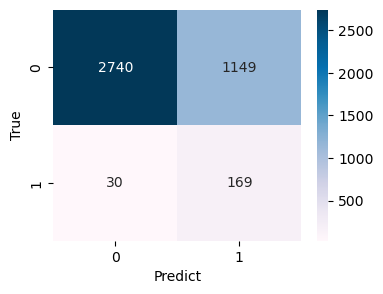

In [223]:
conf_matrix(y_train, y_pred)

Сравним оценки с ранее полученными

In [226]:
for clf in (
    ada_clf, 
    gbt_clf, 
    xgb_clf,
    cat_clf,
    lgb_clf, 
    ):
    y_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
    metrics_new[clf.__class__.__name__] = make_scores(y_train, y_pred)

In [227]:
(pd.DataFrame(metrics_new)
.apply(pd.to_numeric).T.style
.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), vmin=0.1, vmax=0.9, axis=0))

,accuracy_score,precision_score,recall_score,f1_score,roc_auc
SGDClassifier,0.740,0.137,0.819,0.235,0.777
LogisticRegression,0.748,0.140,0.809,0.238,0.777
LinearSVC,0.729,0.133,0.829,0.230,0.777
SVC,0.697,0.115,0.784,0.201,0.738
DecisionTreeClassifier,0.737,0.135,0.814,0.231,0.773
RandomForestClassifier,0.717,0.131,0.854,0.227,0.782
AdaBoostClassifier,0.721,0.127,0.809,0.220,0.763
GradientBoostingClassifier,0.628,0.085,0.683,0.152,0.654
XGBClassifier,0.697,0.125,0.869,0.218,0.779
CatBoostClassifier,0.943,0.238,0.075,0.115,0.532


Как видно, лучший результат по-прежнему у **RandomForestClassifier**. Немного хуже **XGBClassifier**. В завершении попробуем ансамблевые методы

### 5.12 VotingClassifier

Для начала воспользуемся схемой с "жёстким" голосованием

In [228]:
estimators = [
    ('sgd', sgd_clf),
    ('log', log_clf),
    ('svc', svc_clf),
    ('tre', tre_clf),
    ('rnd', rnd_clf),
    ('xgb', xgb_clf),
    ('lgb', lgb_clf)
]

In [229]:
vot_hard = VotingClassifier(estimators=estimators, n_jobs=-1)

In [230]:
vot_hard.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('sgd',
                              SGDClassifier(alpha=0.009953155100371324,
                                            class_weight='balanced',
                                            early_stopping=True,
                                            l1_ratio=0.6755432273340097,
                                            loss='log', n_jobs=-1, penalty='l1',
                                            random_state=42)),
                             ('log',
                              LogisticRegression(C=18.772624592124874,
                                                 class_weight='balanced',
                                                 l1_ratio=0.1349255813367882,
                                                 n_jobs=-1,
                                                 penalty='elasticnet',
                                                 random_state=42, sol...
                                            min_split_loss=37.779732538227684,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=1,
                                            predictor='auto', ...)),
                             ('lgb',
                              LGBMClassifier(boosting='gbdt',
                                             class_weight='balanced',
                                             learning_rate=0.09264161655158663,
                                             max_depth=1, n_estimators=200,
                                             num_leaves=23, random_state=42,
                                             subsample=0.37750632130522427,
                                             subsample_freq=40))],
                 n_jobs=-1)

Попробуем удалить некоторые классификаторы и посмотрим как будет меняться метрика

In [231]:
for est in estimators[:6]:
    vot_hard = vot_hard.set_params(**{est[0]:'drop'})
    y_pred = cross_val_predict(vot_hard, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
    print(f'{est[0]} ROC_AUC = {roc_auc_score(y_train, y_pred)}')

sgd ROC_AUC = 0.7858875245344749
log ROC_AUC = 0.7887489646742326
svc ROC_AUC = 0.792010967669409
tre ROC_AUC = 0.7810239161867449
rnd ROC_AUC = 0.78317661850006
xgb ROC_AUC = 0.7768987648450533


Как видно, можно добиться значения ROC_AUC 0.792!

In [232]:
#vot_hard = vot_hard.set_params(sgd='drop')

Оставим только нужные классификаторы

In [263]:
estimators = [
    ('tre', tre_clf),
    ('rnd', rnd_clf),
    ('xgb', xgb_clf),
    ('lgb', lgb_clf)
]

In [264]:
vot_hard = VotingClassifier(estimators=estimators, n_jobs=-1)

In [265]:
vot_hard.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('tre',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=29,
                                                     max_leaf_nodes=87,
                                                     min_samples_leaf=83,
                                                     min_samples_split=19,
                                                     random_state=42)),
                             ('rnd',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=34,
                                                     max_leaf_nodes=62,
                                                     max_samples=0.8839266254726155,
                                                     min_samples_leaf=65,
                                                     min_samples_split=81,
                                                     n_estimators=125,
                                                     n_j...
                                            min_split_loss=37.779732538227684,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=1,
                                            predictor='auto', ...)),
                             ('lgb',
                              LGBMClassifier(boosting='gbdt',
                                             class_weight='balanced',
                                             learning_rate=0.09264161655158663,
                                             max_depth=1, n_estimators=200,
                                             num_leaves=23, random_state=42,
                                             subsample=0.37750632130522427,
                                             subsample_freq=40))],
                 n_jobs=-1)

In [266]:
y_pred = cross_val_predict(vot_hard, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
make_scores(y_train, y_pred)

{'accuracy_score': '0.736',
 'precision_score': '0.139',
 'recall_score': '0.854',
 'f1_score': '0.239',
 'roc_auc': '0.792'}

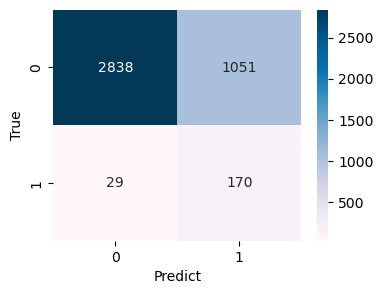

In [267]:
conf_matrix(y_train, y_pred)

Теперь попробуем схему с мягким голосованием

In [276]:
estimators = [
    ('sgd', sgd_clf),
    ('log', log_clf),
    ('tre', tre_clf),
    ('rnd', rnd_clf),
    ('xgb', xgb_clf),
    ('lgb', lgb_clf)
]

In [277]:
vot_soft = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

In [278]:
vot_soft.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('sgd',
                              SGDClassifier(alpha=0.009953155100371324,
                                            class_weight='balanced',
                                            early_stopping=True,
                                            l1_ratio=0.6755432273340097,
                                            loss='log', n_jobs=-1, penalty='l1',
                                            random_state=42)),
                             ('log',
                              LogisticRegression(C=18.772624592124874,
                                                 class_weight='balanced',
                                                 l1_ratio=0.1349255813367882,
                                                 n_jobs=-1,
                                                 penalty='elasticnet',
                                                 random_state=42, sol...
                                            min_split_loss=37.779732538227684,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=1,
                                            predictor='auto', ...)),
                             ('lgb',
                              LGBMClassifier(boosting='gbdt',
                                             class_weight='balanced',
                                             learning_rate=0.09264161655158663,
                                             max_depth=1, n_estimators=200,
                                             num_leaves=23, random_state=42,
                                             subsample=0.37750632130522427,
                                             subsample_freq=40))],
                 n_jobs=-1, voting='soft')

In [279]:
for est in estimators[:5]:
    vot_soft = vot_soft.set_params(**{est[0]:'drop'})
    y_pred = cross_val_predict(vot_soft, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
    print(f'{est[0]} ROC_AUC = {roc_auc_score(y_train, y_pred)}')

sgd ROC_AUC = 0.7858397154194734
log ROC_AUC = 0.7831397925601264
tre ROC_AUC = 0.7896599221357494
rnd ROC_AUC = 0.7847045719727462
xgb ROC_AUC = 0.7768987648450533


С "мягким" голосованием точность получилась ниже

In [280]:
estimators = [
    ('rnd', rnd_clf),
    ('xgb', xgb_clf),
    ('lgb', lgb_clf)
]

In [281]:
vot_soft = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

In [282]:
vot_soft.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('rnd',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=34,
                                                     max_leaf_nodes=62,
                                                     max_samples=0.8839266254726155,
                                                     min_samples_leaf=65,
                                                     min_samples_split=81,
                                                     n_estimators=125,
                                                     n_jobs=-1, oob_score=True,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode...
                                            min_split_loss=37.779732538227684,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=1,
                                            predictor='auto', ...)),
                             ('lgb',
                              LGBMClassifier(boosting='gbdt',
                                             class_weight='balanced',
                                             learning_rate=0.09264161655158663,
                                             max_depth=1, n_estimators=200,
                                             num_leaves=23, random_state=42,
                                             subsample=0.37750632130522427,
                                             subsample_freq=40))],
                 n_jobs=-1, voting='soft')

In [283]:
y_pred = cross_val_predict(vot_soft, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
make_scores(y_train, y_pred)

{'accuracy_score': '0.709',
 'precision_score': '0.130',
 'recall_score': '0.879',
 'f1_score': '0.227',
 'roc_auc': '0.790'}

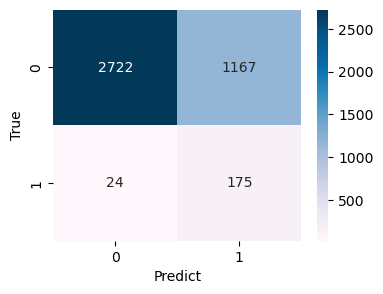

In [284]:
conf_matrix(y_train, y_pred)

### 5.13 StackingClassifier

In [249]:
estimators = [
    ('sgd', sgd_clf),
    ('log', log_clf),
    ('svc', svc_clf),
    ('tre', tre_clf),
    ('rnd', rnd_clf),
    ('xgb', xgb_clf),
    ('lgb', lgb_clf)
]

In [250]:
sta_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=log_clf,
    cv=skf,
    n_jobs=-1
)

In [251]:
sta_clf.fit(X_train_encoded, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimators=[('sgd',
                                SGDClassifier(alpha=0.009953155100371324,
                                              class_weight='balanced',
                                              early_stopping=True,
                                              l1_ratio=0.6755432273340097,
                                              loss='log', n_jobs=-1,
                                              penalty='l1', random_state=42)),
                               ('log',
                                LogisticRegression(C=18.772624592124874,
                                                   class_weight='balanced',
                                                   l1_ratio=0.13492...
                                               class_weight='balanced',
                                               learning_rate=0.09264161655158663,
                                               max_depth=1, n_estimators=200,
                                               num_leaves=23, random_state=42,
                                               subsample=0.37750632130522427,
                                               subsample_freq=40))],
                   final_estimator=LogisticRegression(C=18.772624592124874,
                                                      class_weight='balanced',
                                                      l1_ratio=0.1349255813367882,
                                                      n_jobs=-1,
                                                      penalty='elasticnet',
                                                      random_state=42,
                                                      solver='saga',
                                                      tol=0.001),
                   n_jobs=-1)

In [252]:
y_pred = cross_val_predict(sta_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
make_scores(y_train, y_pred)

{'accuracy_score': '0.740',
 'precision_score': '0.114',
 'recall_score': '0.643',
 'f1_score': '0.194',
 'roc_auc': '0.694'}

In [253]:
for est in estimators[:6]:
    sta_clf = sta_clf.set_params(**{est[0]:'drop'})
    y_pred = cross_val_predict(sta_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
    print(f'{est[0]} ROC_AUC = {roc_auc_score(y_train, y_pred)}')

sgd ROC_AUC = 0.7491352364806807
log ROC_AUC = 0.7546307004293776
svc ROC_AUC = 0.7543845480940317
tre ROC_AUC = 0.7717890041619774
rnd ROC_AUC = 0.691996883362557
xgb ROC_AUC = 0.7679649210309712


In [254]:
estimators = [
    ('rnd', rnd_clf),
    ('xgb', xgb_clf),
    ('lgb', lgb_clf)
]

In [255]:
sta_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=log_clf,
    cv=skf,
    n_jobs=-1
)

In [256]:
sta_clf.fit(X_train_encoded, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimators=[('rnd',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=34,
                                                       max_leaf_nodes=62,
                                                       max_samples=0.8839266254726155,
                                                       min_samples_leaf=65,
                                                       min_samples_split=81,
                                                       n_estimators=125,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=0.5, booste...
                                               class_weight='balanced',
                                               learning_rate=0.09264161655158663,
                                               max_depth=1, n_estimators=200,
                                               num_leaves=23, random_state=42,
                                               subsample=0.37750632130522427,
                                               subsample_freq=40))],
                   final_estimator=LogisticRegression(C=18.772624592124874,
                                                      class_weight='balanced',
                                                      l1_ratio=0.1349255813367882,
                                                      n_jobs=-1,
                                                      penalty='elasticnet',
                                                      random_state=42,
                                                      solver='saga',
                                                      tol=0.001),
                   n_jobs=-1)

In [257]:
y_pred = cross_val_predict(sta_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
make_scores(y_train, y_pred)

{'accuracy_score': '0.675',
 'precision_score': '0.118',
 'recall_score': '0.879',
 'f1_score': '0.208',
 'roc_auc': '0.772'}

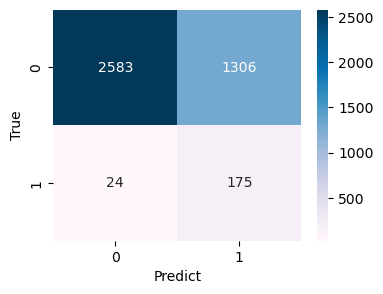

In [258]:
conf_matrix(y_train, y_pred)

In [268]:
for clf in (
    vot_hard, 
    sta_clf 
    ):
    y_pred = cross_val_predict(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, method='predict')
    metrics_new[clf.__class__.__name__] = make_scores(y_train, y_pred)

## 6. Проверка на тестовом датасете

Подведём итоги

In [269]:
(pd.DataFrame(metrics_new)
.apply(pd.to_numeric).T.style
.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), vmin=0.1, vmax=0.9, axis=0))

,accuracy_score,precision_score,recall_score,f1_score,roc_auc
SGDClassifier,0.740,0.137,0.819,0.235,0.777
LogisticRegression,0.748,0.140,0.809,0.238,0.777
LinearSVC,0.729,0.133,0.829,0.230,0.777
SVC,0.697,0.115,0.784,0.201,0.738
DecisionTreeClassifier,0.737,0.135,0.814,0.231,0.773
RandomForestClassifier,0.717,0.131,0.854,0.227,0.782
AdaBoostClassifier,0.721,0.127,0.809,0.220,0.763
GradientBoostingClassifier,0.628,0.085,0.683,0.152,0.654
XGBClassifier,0.697,0.125,0.869,0.218,0.779
CatBoostClassifier,0.943,0.238,0.075,0.115,0.532


Как видно, лучшее значение у классификатора с жёстким голосованием. Теперь проверим метрики на тестовом датасете

Подготовим тестовый датасет

In [285]:
stroke_test.bmi = stroke_test.bmi.fillna(stroke_train.bmi.mean())

In [286]:
#stroke_test.bmi[stroke_test.bmi > boundaries.bmi.max()] = boundaries.bmi.max()

In [287]:
stroke_test['age_category'] = pd.cut(stroke_test.age,
                                     bins=[0, 50, 60, 70, np.inf], 
                                     labels=[1, 2, 3, 4]).astype(int)

In [288]:
stroke_test['ever_smoking'] = stroke_test.apply(lambda x: 1 
                                                if x.smoking_status in ['smokes', 'formerly smoked'] 
                                                else 0, axis=1)

In [289]:
stroke_test['diabeth'] = stroke_test.avg_glucose_level.map(lambda x: 1 if x>160 else 0)

In [290]:
stroke_test['diseases'] = stroke_test.apply(lambda x: x.diabeth+x.hypertension+x.heart_disease+x.ever_smoking, axis=1)

In [291]:
stroke_test = stroke_test.drop(['gender', 'Residence_type'], axis=1)

In [292]:
X_test = stroke_test.drop(['stroke'], axis=1)
y_test = stroke_test.stroke.copy()

In [293]:
X_test_encoded = prep.transform(X_test)

In [294]:
metrics_test = {}
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf,
    ada_clf, 
    gbt_clf, 
    xgb_clf,
    cat_clf,
    lgb_clf, 
    vot_hard,
    sta_clf
    ):
    y_pred = clf.predict(X_test_encoded)
    metrics_test[clf.__class__.__name__] = make_scores(y_test, y_pred)

In [295]:
(pd.DataFrame(metrics_test)
.apply(pd.to_numeric).T.style
.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), vmin=0.1, vmax=0.9, axis=0))

,accuracy_score,precision_score,recall_score,f1_score,roc_auc
SGDClassifier,0.753,0.142,0.800,0.241,0.776
LogisticRegression,0.747,0.141,0.820,0.240,0.781
LinearSVC,0.746,0.140,0.820,0.240,0.781
SVC,0.688,0.103,0.700,0.180,0.694
DecisionTreeClassifier,0.744,0.137,0.800,0.234,0.770
RandomForestClassifier,0.740,0.135,0.800,0.231,0.768
AdaBoostClassifier,0.706,0.123,0.820,0.215,0.760
GradientBoostingClassifier,0.295,0.014,0.200,0.027,0.250
XGBClassifier,0.698,0.120,0.820,0.210,0.756
CatBoostClassifier,0.944,0.267,0.080,0.123,0.534


Как видно, лучшее значение показала логистическая регрессия, не смотря на то, что на тестовом датасете значение ROC_AUC было не самым оптимальным. Сравним, как сильно отличаются значения метрик

In [296]:
diff_metrics(metrics_test, metrics_new)

,accuracy_score,precision_score,recall_score,f1_score,roc_auc
SGDClassifier,1.76,3.65,-2.32,2.55,-0.13
LogisticRegression,-0.13,0.71,1.36,0.84,0.51
LinearSVC,2.33,5.26,-1.09,4.35,0.51
SVC,-1.29,-10.43,-10.71,-10.45,-5.96
DecisionTreeClassifier,0.95,1.48,-1.72,1.30,-0.39
RandomForestClassifier,3.21,3.05,-6.32,1.76,-1.79
AdaBoostClassifier,-2.08,-3.15,1.36,-2.27,-0.39
GradientBoostingClassifier,-53.03,-83.53,-70.72,-82.24,-61.77
XGBClassifier,0.14,-4.00,-5.64,-3.67,-2.95
CatBoostClassifier,0.11,12.18,6.67,6.96,0.38


Метрики на тестовом датасете ожидаемо "просели", но не сильно, за исключением **LogisticRegression**, **LinearSVC**, **CatBoostClassifier**. Очень сильно "упали" метрики у градиентного бустинга, который оказался переученным.

Выведем матрицу ошибок для нашей лучшей модели

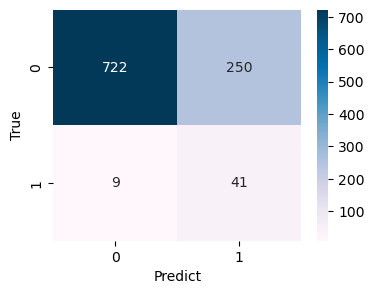

In [298]:
best_model = log_clf
conf_matrix(y_test, best_model.predict(X_test_encoded))

Как видно, из 50 пациентов мы угадали 41 и еще вдобавок "прихватили" 250 здоровых из 972 пациентов!

## 7. Настройка точность/полнота

Учитывая, что инсульт опасное заболевание, попробуем поднять _полноту (precision)_. Для начала выведем зависимость между _точностью_ и _полнотой_

In [303]:
scores = cross_val_predict(best_model, X_train_encoded, y_train, cv=skf, n_jobs=-1, method="decision_function")

In [304]:
precisions, recalls, thresholds = precision_recall_curve(y_train, scores)

Строим график

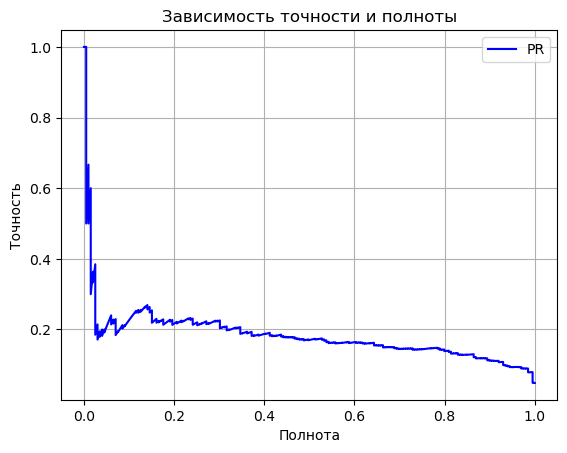

In [332]:
plt.plot(recalls, precisions, 'b-', label='PR')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('Зависимость точности и полноты');

Видно, что улучшение полноты неизбежно приведёт к уменьшению точности

Можно также вывести значения порогов, которые определяют соотношение точности и полноты

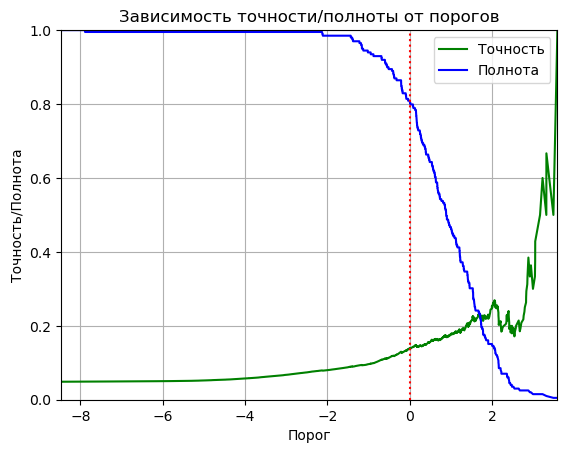

In [331]:
plt.plot(thresholds, precisions[:-1], 'g-', label='Точность')
plt.plot(thresholds, recalls[:-1], 'b-', label='Полнота')
plt.xlabel('Порог')
plt.ylabel('Точность/Полнота')
plt.legend(loc='upper right')
plt.grid(True)
plt.axis([scores.min(), scores.max(), 0, 1])
plt.axvline(x=0, color='r', linestyle=':')
plt.title('Зависимость точности/полноты от порогов');

В текущий момент мы находимся в нулевом пороге (красная пунктирная линия). Попробуем поднять полноту до 95%. Для этого нам придётся перемещаться влево. Вычислим значение порога для нужной полноты

In [357]:
precision = precisions[np.argmax(recalls <= 0.95)]
threshold = thresholds[np.argmax(recalls <= 0.95)]

In [358]:
precision, threshold

(0.09319526627218935, -1.1594656870886966)

Как видно, при полноте 95 % мы получим точность 9,3 %. Мы помним, при полноте 81 % точность была 14 %.

Вычислим новые предсказания

In [364]:
y_pred_new = (scores >= threshold).astype(int) 

In [365]:
make_scores(y_train, y_pred_new)

{'accuracy_score': '0.548',
 'precision_score': '0.093',
 'recall_score': '0.950',
 'f1_score': '0.170',
 'roc_auc': '0.738'}

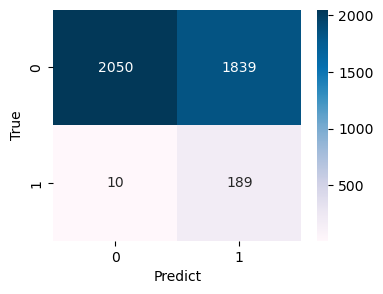

In [366]:
conf_matrix(y_train, y_pred_new)

Как видно, мы не определили инсульт только у 10 человек, при этом примерно половина здоровых пациентов попала в группу FP (false positive). Это и есть цена нашей высокой полноты. В данном случае, возможно, это даже не плохо 

In [367]:
scores_test = best_model.decision_function(X_test_encoded)

In [374]:
y_pred_test = (scores_test >= threshold).astype(int) 

In [375]:
make_scores(y_test, y_pred_test)

{'accuracy_score': '0.549',
 'precision_score': '0.087',
 'recall_score': '0.860',
 'f1_score': '0.157',
 'roc_auc': '0.696'}

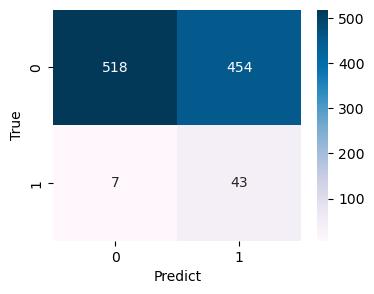

In [376]:
conf_matrix(y_test, y_pred_test)

Получилось не очень хорошо, а точнее совсем плохо! Нам удалось дополнительно идентифицировать двух человек с инсультом, при этом мы "захватили" еще 200 человек без инсульта. 

## 8. Заключение

В данной работе мы пытались предсказать у пациентов инсульт, то есть нам предстояло решить задачу бинарной классификации. 
Для этого применялись различные модели. Из всего многообразия только модель _логистической регрессии_ показала оптимальный 
и стабильный результат. Также мы поптытались увеличить полноту предсказания. Но, к сожалению, на тестовом датасете это не 
привело к хорошему результату.